# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

**Импортируем библиотеку pandas и другие. Считываем данные из csv-файла в датафрейм и сохраните в переменную `data`. Путь к файлу:**

`/datasets/real_estate_data.csv`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
except:
    data = pd.read_csv('/Users/a0000/Documents/Analitic/All_projects/project2_apartments_research/datasets/real_estate_data.csv',sep='\t')

✔️ 

In [3]:
data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


**Изучим файл использовав метод `info()`**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Построим гистограмму для всех числовых столбцов таблицы на одном графике.**

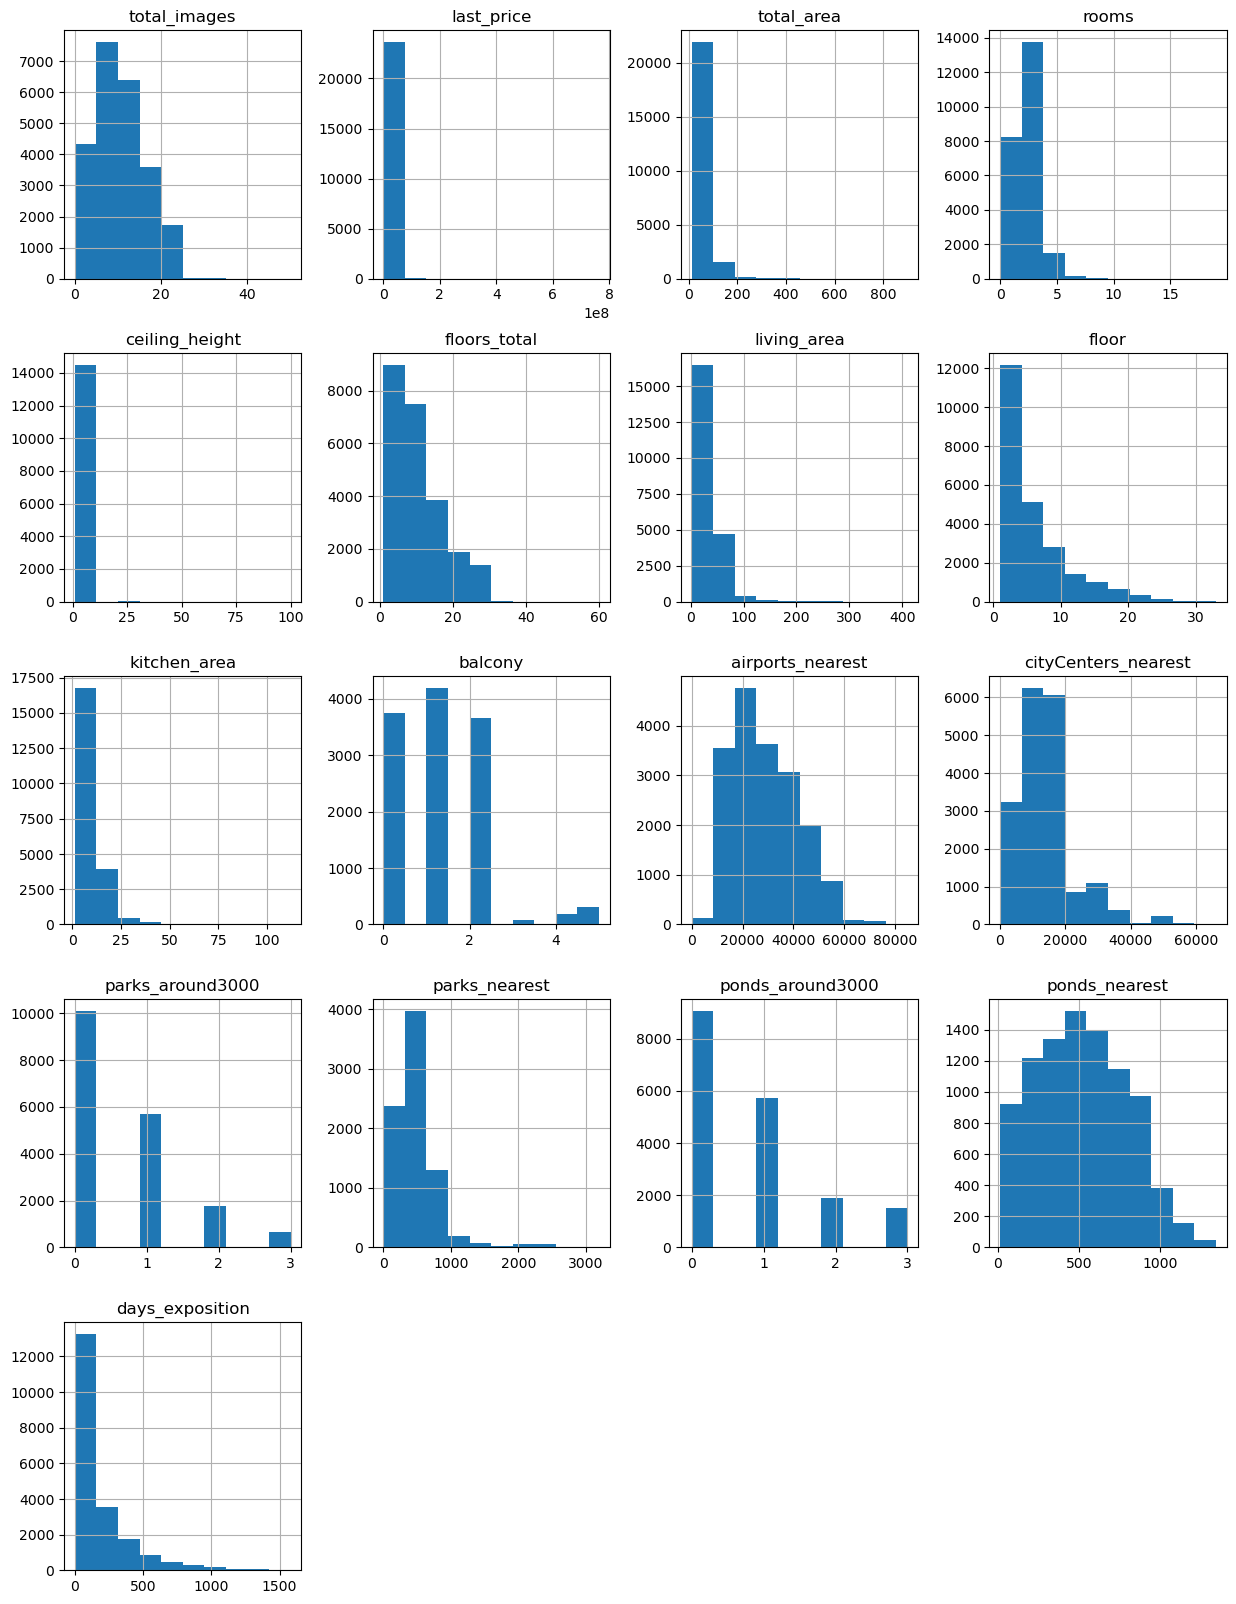

In [5]:
data.hist(figsize=(15, 20));

- total_images - По графику видно, что большинство обьявления содержут по 10 фотографий, но есть и выбросы до 40
- last_price, total_area,ceiling_height,floors_total,living_area,kitchen_area  - графики требует более детального изучения, так как не показывает точной информации 
- rooms, floor, balcony,parks_around3000,ponds_around3000,days_exposition - показывают более лучшую картину, но тоже требует подробного изучения
- cityCenters_nearest, airports_nearest, parks_nearest, ponds_nearest - графики с расстояния тоже нуждаются в подробном изученни, для получения дальнейших зависмостей

### Выполните предобработку данных

 **Найдем и изучим пропущенные значения в столбцах:**

Определим, в каких столбцах есть пропуски с помощью `isna().sum()`

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Заполним пропущенные значения в `ceiling_height`**

Заполним пропущенные значения высоты потолковов медианным значением по группам, в старых районах рассположенных в пределах 7000 метров, высота потолков выше, в новых на расстоянии больше 7000 метрв, где строят нововстройки по современным стандартам, высота потолков будет ниже

In [7]:
data['distance_category'] = data['cityCenters_nearest'].apply(lambda x: 'within_7000m' if x <= 7000 else 'beyond_7000m')

# Вычисление медианной высоты потолков для каждой категории
median_heights = data.groupby('distance_category')['ceiling_height'].median()

# Заполнение пропусков в высоте потолков, используя медианные значения для каждой категории
data['ceiling_height'] = data.apply(
    lambda row: median_heights[row['distance_category']] if pd.isna(row['ceiling_height']) else row['ceiling_height'],
    axis=1
)

✔️ 

**Заполним пропущенные значения в `floors_total`**

Количество пропущенных значений этажей в доме составляет менее 0.4% от общего числа данных, поэтому их удаление маловероятно окажет значительное влияние на общий анализ или результаты статистического моделирования.

In [8]:
data.dropna(subset=['floors_total'], inplace=True)


**Заполним пропущенные значения в `living_area`**

Количество пропущенных значений в `living_area` заменим по следующему принципу 
1) разобьем на группы `total_area` - это общая квадратура кватиры,первая группа - это размер до 50 кв. м. ,вторая от 50 до 100 кв. м. ,третья от 100 кв. м.

2) найдем медианное значение `living_area` для кадой группы `total_area`

3) заменим пропущенные значения `living_area` в каждой группе на медианные значения по группам

In [9]:
total_area_30 = data['total_area'] < 30
total_area_30_45 = (data['total_area'] >= 30) & (data['total_area'] < 45)
total_area_45_60 = (data['total_area'] >= 45) & (data['total_area'] < 60)
total_area_60_100 = (data['total_area'] >= 60) & (data['total_area'] < 100)
total_area_100 = data['total_area'] >= 100

group_area = [total_area_30,total_area_30_45,total_area_45_60,total_area_60_100,total_area_100]

for item in group_area:
    data.loc[item & data['living_area'].isnull(), 'living_area'] = data.loc[item, 'living_area'].median()


**Заполним пропущенные значения в `is_apartment`**

Так как `is_apartment` имеет булевые значения, лучше эти данные не заполнять и оставить как есть, чтобы исключить искажение данных

**Заполним пропущенные значения в `balcony`**

In [10]:
data['balcony'].fillna(value=0, inplace=True)

Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски можно заменить на число 0

**Заполним пропущенные значения в `kitchen_area`**

Количество пропущенных значений в `kitchen_area` заменим по следующему принципу 
Вычтем из общей, жилую c учетом сан узла, балкона , коридора, которые занимают примерно 10% от общей плоащди

In [11]:
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] = data['total_area'] * 0.9 - data['living_area']


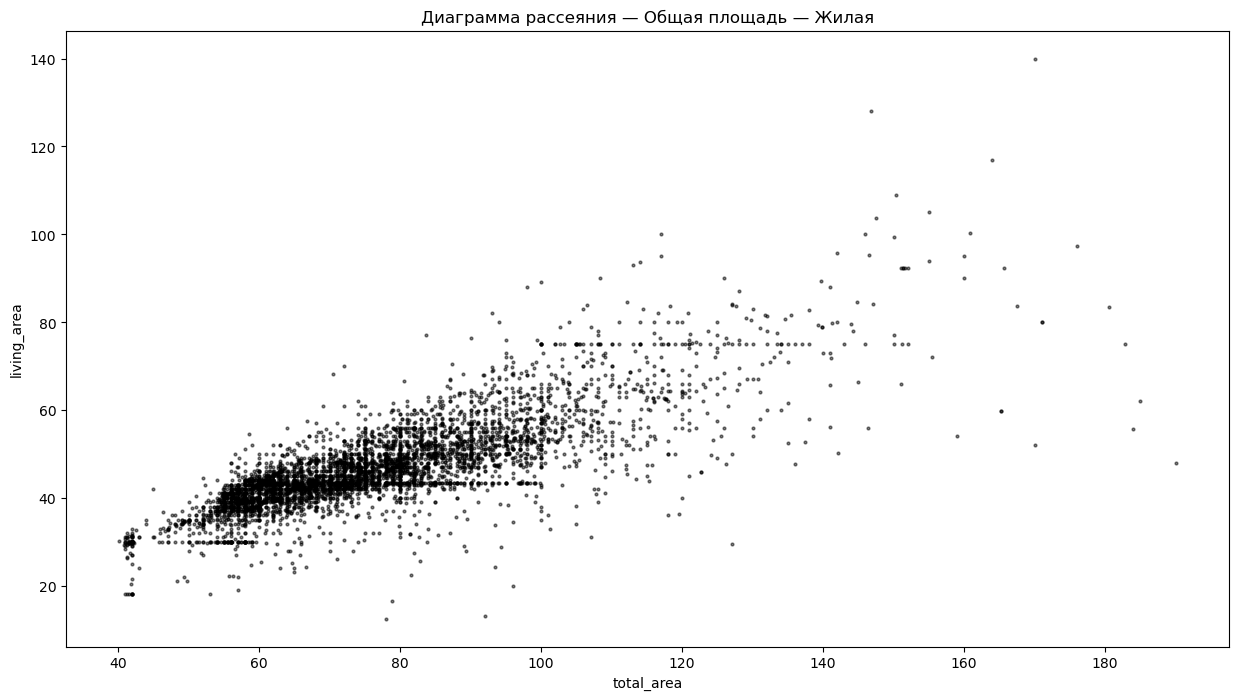

In [12]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

**Заполним пропущенные значения в `locality_name`**

Количество пропущенных значений этажей в доме составляет менее 0.3% от общего числа данных, поэтому их удаление маловероятно окажет значительное влияние на общий анализ или результаты статистичес

In [13]:
data.dropna(subset=['locality_name'], inplace=True)

**Заполним пропущенные значения в `airports_nearest`**

Заполнение пропущенных значений может ввести искажения в анализ, особенно если используемые для заполнения методы (например, среднее или медиана) не точно отражают реальное положение вещей. Если расстояние до аэропорта сильно варьируется в зависимости от других факторов (как географическое положение), любые предположения могут быть неточными.

Если пропуски в данных о расстоянии до аэропорта систематичны (например, отсутствуют для определённых населённых пунктов или типов жилья), это само по себе может нести важную информацию. Заполнение таких пропусков может скрыть взаимосвязь между отсутствием данных и другими характеристиками объектов. Поэтому оставим пропуски как есть 

**Заполним пропущенные значения в `cityCenters_nearest`**

Оставим пропуски как есть, исходя из той же логике, что мы описали в `airports_nearest`

**Заполним пропущенные значения в `parks_around3000`**

Если в `parks_around3000` стоит значение Nan , значит парков в радиусе 3 км нету, поэтому вместе Nan поставим 0

In [14]:
data['parks_around3000'].fillna(value=0, inplace=True)

**Заполним пропущенные значения в `parks_nearest`**

Для начала изучим сколько у нас пропущенных и не пропущенных значений для каждой группы

In [15]:
missing_parks = (
    data.groupby('locality_name')
    .agg(
        missing_parks_count=('parks_nearest', lambda x: x.isnull().sum()),  
        existing_parks_count=('parks_nearest', lambda x: x.notnull().sum())
    )
    .sort_values(by='existing_parks_count',ascending=False).head(12)
)
missing_parks

,missing_parks_count,existing_parks_count
locality_name,,
Санкт-Петербург,8400,7251
Пушкин,157,212
Петергоф,58,143
Колпино,205,133
Кронштадт,9,87
Сестрорецк,111,72
Красное Село,131,45
Павловск,12,26
посёлок Стрельна,24,19


Мы выделили все значения с некоторым числом квартир, в городах где указано расстояние до ближайшего парка, эти пропущенные значения заполним медианной по каждой группе

In [16]:
median_parks_nearest = data.groupby('locality_name')['parks_nearest'].median()
data['parks_nearest'] = data.apply(
    lambda row: median_parks_nearest[row['locality_name']] if pd.isnull(row['parks_nearest']) else row['parks_nearest'],
    axis=1
)

Мы заполнили все значения, которые могли, из-за нехватки данных оставшиеся пропущенные значения заполнить не будем , чтобы получить более точную картину исследования 

Наличие оставшихся пропусков, не окажет достаточно сильного влияния на покупку квартиры, так как люди при выборе квартиры опираются на более нужные им параметры, а наличие парка это просто приятное дополнение к квартире

**Заполним пропущенные значения в `ponds_around3000`**

Если в `ponds_around3000` стоит значение Nan , значит водоемов в радиусе 3 км нету, поэтому вместе Nan поставим 0

In [17]:
data['ponds_around3000'].fillna(value=0, inplace=True)

**Заполним пропущенные значения в `ponds_nearest`**

Для начала изучим сколько у нас пропущенных и не пропущенных значений для каждой группы

In [18]:
missing_ponds = (
    data.groupby('locality_name')
    .agg(
        missing_ponds_count=('ponds_nearest', lambda x: x.isnull().sum()),  
        existing_ponds_count=('ponds_nearest', lambda x: x.notnull().sum())
    )
    .sort_values(by='existing_ponds_count',ascending=False).head(18)
)
missing_ponds

,missing_ponds_count,existing_ponds_count
locality_name,,
Санкт-Петербург,7715,7936
Колпино,148,190
Пушкин,192,177
посёлок Шушары,287,152
Сестрорецк,48,135
Петергоф,84,117
Кронштадт,9,87
Ломоносов,50,83
посёлок Парголово,271,56


Мы выделили все значения с некоторым числом квартир, в городах где указано расстояние до ближайшего водоема, эти пропущенные значения заполним медианной по каждой группе

In [19]:
median_ponds_nearest = data.groupby('locality_name')['ponds_nearest'].median()
data['ponds_nearest'] = data.apply(
    lambda row: median_ponds_nearest[row['locality_name']] if pd.isnull(row['ponds_nearest']) else row['ponds_nearest'],
    axis=1
)

Мы заполнили все значения, которые могли, из-за нехватки данных оставшиеся пропущенные значения заполнять не будем , чтобы получить более точную картину исследования 

Наличие оставшихся пропусков, не окажет достаточно сильного влияния на покупку квартиры, так как люди при выборе квартиры опираются на более нужные им параметры, а наличие водоема это просто приятное дополнение к квартире

**Заполним пропущенные значения в `days_exposition`**

Пропуски в `days_exposition` оставим без изменения, так как обьявление еще активно

**Причины, которые могли привести к пропускам в данных.**


- **Неуказанная информация**: Данные могли не быть внесены по разным причинам, таким как недоступность на момент ввода.
- **Ошибки при сборе данных**: Пропуски могут быть вызваны как ошибками при автоматическом, так и при ручном сборе данных.
- **Технические ошибки**: Сбои в системах или ошибки программного обеспечения могут привести к потере данных.
- **Опциональные поля**: Некоторые данные могут быть необязательными к заполнению, что приводит к пропускам в них.
- **Цензура или удаление данных**: Данные могут быть удалены из соображений конфиденциальности или цензуры.


**Рассмотрим типы данных в каждом столбце:**

Сейчас этот столбец имеет тип object, что обычно соответствует строковому типу в pandas. Так как `first_day_exposition`это дата публикации, лучше преобразовать его в тип datetime для более удобной работы с датами:

In [20]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

Cтолбец `is_apartment` также имеет тип object. Поскольку предполагается, что это булев тип (апартаменты или нет), можно преобразовать его в bool, если данные принимают значения True/False:

#### check bool

In [21]:
# check
data['is_apartment'].value_counts()

is_apartment
False    2710
True       50
Name: count, dtype: int64

Cтолбец `balcony` указан как float64, если количество балконов всегда целое число, можно рассмотреть возможность преобразования его в int64:

In [22]:
data['balcony'] = data['balcony'].astype(int)


Cтолбец `floors_total` также имеет тип float64, что может быть нецелесообразно, если количество этажей всегда является целым числом. Можно перевести его в int64,

In [23]:
data['floors_total'] = data['floors_total'].astype(int)

Столбцы `parks_around3000`, `ponds_around3000` -  указывают на количество парков и водоёмов в радиусе 3 км и должны быть целочисленными:

In [24]:
parks_ponds = ['parks_around3000','ponds_around3000']

for item in parks_ponds:
    data[item] = data[item].astype(int)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony              

**Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты.**

Избавимся от явных дубликатов. Воспользуемся цепочкой методов replace().

In [26]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')  
    .replace({
        'поселок городского типа ': 'поселок ', 
        'городской поселок ': 'поселок ',  
        'при железнодорожной станции ': 'поселок станции ',
        'садоводческое некоммерческое товарищество ': '',
        'коттеджный поселок ': 'поселок ',
    }, regex=True)
)

#### check name

In [27]:
# check
data.locality_name.nunique()

321

In [28]:
# check
data.locality_name.unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Федоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

### Добавьте в таблицу новые столбцы

**Добавим столбец цены одного квадратного метра и округлим до двух знаков после запятой:**

In [29]:
data['price_of_one_metr'] = (data['last_price'] / data['total_area']).round(2)

**Добавим столбец день недели публикации объявления (0 - понедельник, 1 - вторник и так далее):**

In [30]:
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek

**Добавим столбец месяц публикации объявления:**

In [31]:
data['month'] = data['first_day_exposition'].dt.month

**Добавим столбец год публикации объявления:**

In [32]:
data['year'] = data['first_day_exposition'].dt.year

**Добавим столбец тип этажа квартиры (значения - «первый», «последний», «другой»);**

In [33]:
data['type_of_floor'] = data.apply(
    lambda row: ('первый' if row['floor'] == 1 else 'последний') if row['floor'] == row['floors_total']
    else ('первый' if row['floor'] == 1 else 'другой'), 
    axis=1
)

**Добавим столбец расстояние до центра города в километрах (переведем из м в км и
округлим до ближайших целых значений).**

In [34]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round(0)

In [35]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23565 non-null  int64         
 1   last_price              23565 non-null  float64       
 2   total_area              23565 non-null  float64       
 3   first_day_exposition    23565 non-null  datetime64[ns]
 4   rooms                   23565 non-null  int64         
 5   ceiling_height          23565 non-null  float64       
 6   floors_total            23565 non-null  int64         
 7   living_area             23565 non-null  float64       
 8   floor                   23565 non-null  int64         
 9   is_apartment            2760 non-null   object        
 10  studio                  23565 non-null  bool          
 11  open_plan               23565 non-null  bool          
 12  kitchen_area            23565 non-null  float64    

### Проведите исследовательский анализ данных

**Изучим перечисленные ниже параметры объектов и построим отдельные гистограммы для каждого из этих параметров.**

**Список параметров:**

- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка

**Изучим параметр общая площадь и пострим гистограмму**

Разумнее сосредоточиться на диапазоне от 20 до 200 квадратных метров. Этот диапазон включает подавляющее большинство данных, что делает его наиболее подходящим для анализа спроса на жилье.

Исключим выбросы данных (слишком редкие значения) ,чтобы гистограмма стала более информативной

In [36]:
data = data.query('20 < total_area < 200')

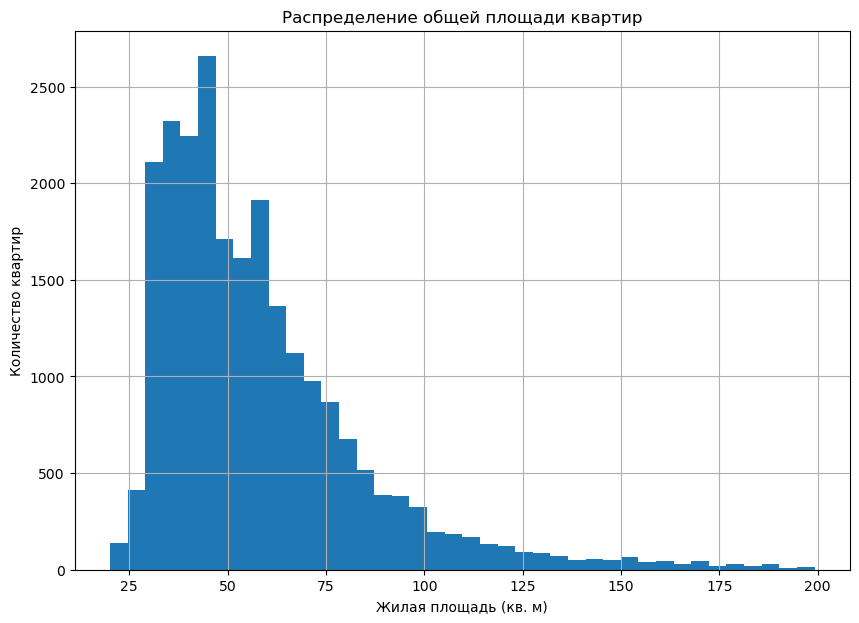

In [37]:
data['total_area'].hist(bins=40,figsize=(10,7))
plt.xlabel('Жилая площадь (кв. м)')
plt.ylabel('Количество квартир')
plt.title('Распределение общей площади квартир');

Наибольшее количество квартир находится в диапазоне от 30 до 60 квадратных метров, что указывает на наиболее распространённые размеры квартир.

**Изучим параметр жилая площадь и пострим гистограмму**

Изначально гистограмма показывает данные до 180 квадратных метров, значительное количество данных сосредоточено от 10 до 110 квадратных метров. После этого значения количество квартир резко уменьшается. Разумно сосредоточить внимание на диапазоне жилой площади до 100 квадратных метров. Этот диапазон охватывает основную массу квартир, и данные в этом диапазоне будут наиболее подходящие для типичных жилых условий.

Исключим выбросы данных (слишком редкие значения) ,чтобы гистограмма стала более информативной

In [38]:
data = data.query(' 10 < living_area < 110')

In [39]:
# check
data.shape[0]

23150

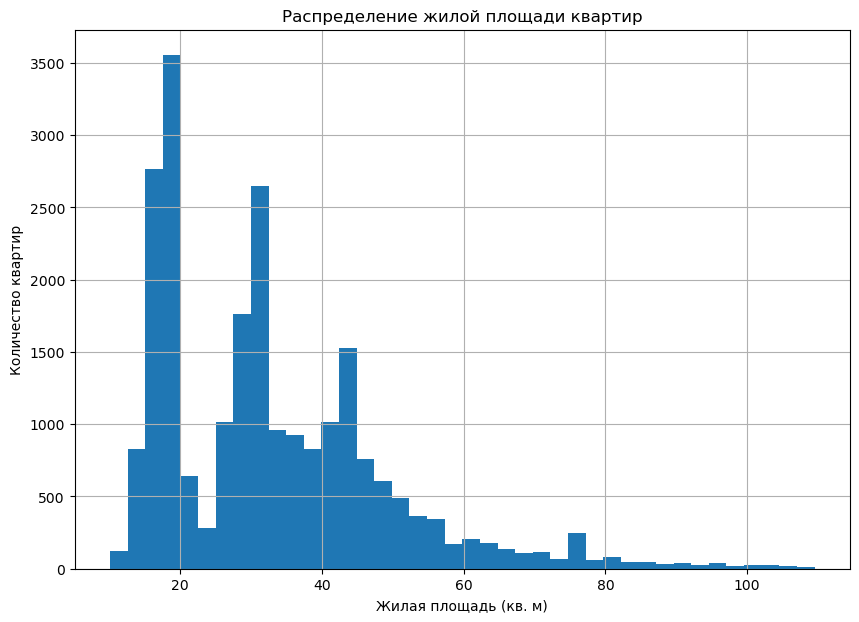

In [40]:
data['living_area'].hist(bins = 40,figsize = (10,7))
plt.xlabel('Жилая площадь (кв. м)')
plt.ylabel('Количество квартир')
plt.title('Распределение жилой площади квартир');

Основной пик: Самый высокий пик наблюдается в интервале от 15 до 20 квадратных метров. Это может быть связано с тем, что многие квартиры имеют маленькую жилую площадь, что типично для студий или малогабаритных квартир.

Вторичные пики: Второй пик виден около от 10 до 15 квадратных метров, с последующими меньшими пиками около 30 и 40 квадратных метров. Это указывает на разнообразие типов квартир в данных, отражая наличие однокомнатных и двухкомнатных квартир.

Снижение частоты с увеличением площади: Частота квартир уменьшается по мере увеличения жилой площади, что характерно для рынка недвижимости, где большие квартиры встречаются реже.

Данные доходят до 110 квадратных метров, но основная масса расположена в первой трети диапазона. Более крупные квартиры после 45 квадратных метров занимают меньшую часть рынка.

**Изучим параметр площадь кухни и пострим гистограмму**

Изначально гистограмма покказывает данные до 90 квадратных метров, поставим верхнюю границу примерно от 4 до 40 квадратных метров. После этой отметки количество квартир с такой площадью кухни значительно снижается, что делает их редкостью и не слишком подходящей для общей выборки.

In [41]:
data = data.query('4 < kitchen_area < 50')

In [42]:
# check
data.shape[0]

22938

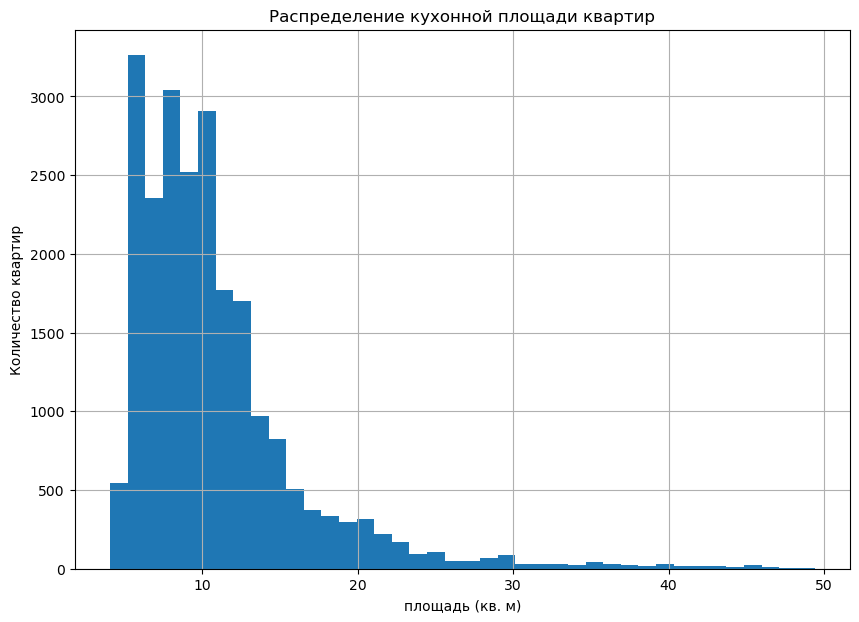

In [43]:
data['kitchen_area'].hist(bins=40,figsize = (10,7))
plt.xlabel('площадь (кв. м)')
plt.ylabel('Количество квартир')
plt.title('Распределение кухонной площади квартир');

На гистограмме площади кухонь видно, что большинство кухонь имеют площадь между 5 и 10 квадратными метрами. Далле идет спад, так как значений становиться меньше из-за увеличения общей площади квартир которых преимущественно меньше в сравнении с маленькими квартирами

**Изучим параметр цена объекта и пострим гистограмму**

Чтобы получить более наглядную гистограмму, создадим новый в стобец цены, в которой переведем значения из рублей в миллионы

Цены на нашей гистограмме доходят до 289 миллионов за квартиру, отбросим слишком малые количественные показатели, чтобы получить более аккуратный анализ рыночных условий и уменьшения влияния аномалий можно рассмотреть возможность ограничения данных для анализа. Исключим из анализа квартиры стоимостью более 20 миллионов, так как они составляют меньшинство и могут исказить общие выводы о рынке. Это позволит сфокусироваться на более типичных для большинства покупателей ценовых категориях.

In [44]:
data['last_price_million'] = data['last_price']/1000000

In [45]:
data = data.query('last_price_million < 20')

In [46]:
# check
data.shape[0]

22493

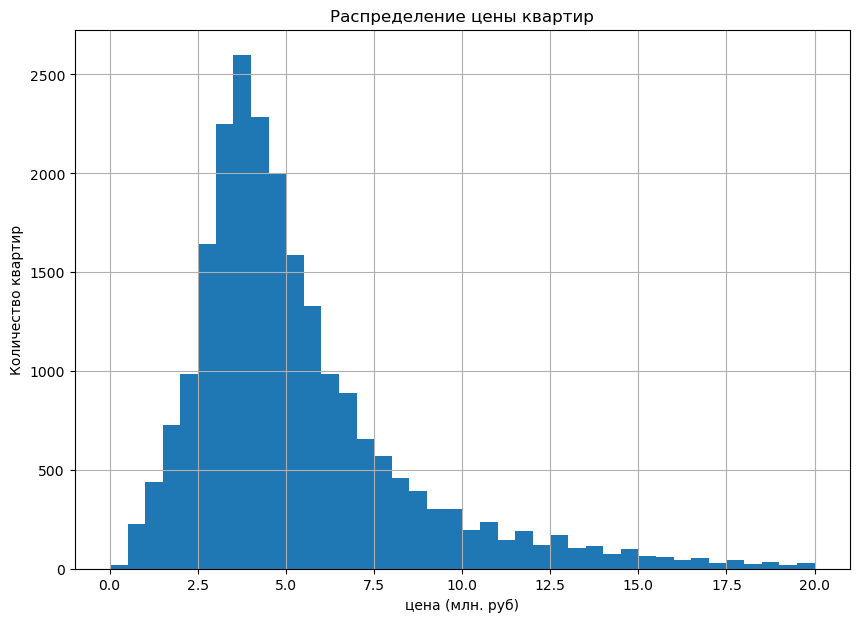

In [47]:
data['last_price_million'].hist(bins=40,figsize=(10,7))
plt.xlabel('цена (млн. руб)')
plt.ylabel('Количество квартир')
plt.title('Распределение цены квартир');

Основная масса предложений сосредоточена от 2.5 до 6.5 миллионов, после чего количество предложений существенно снижается. На гистограмме видно, что квартиры с ценой выше 10 миллионов представлены уже значительно реже, и их количество уменьшается с увеличением цены.

**Изучим параметр количество комнат и пострим гистограмму**

Максильное количество комнат 8, так же присутсвуют данные с 0 комнатами, выберем диапазон от 1 до 5 комнат, отбросим выбросы с 6 до 8 комнат и получим более точную гистограмму для последующего анализа

In [48]:
data = data.query('0 < rooms < 6')

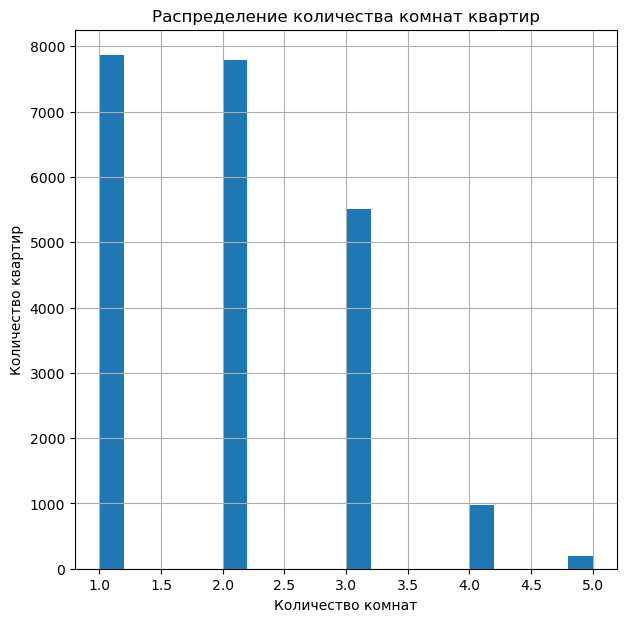

In [49]:
data['rooms'].hist(bins = 20, figsize = (7,7))
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.title('Распределение количества комнат квартир');

Мы можем наблюдать, что квартиры с количеством комнат 1 и 2 пользуются большим спросом чем остальне, после 3 комнат спрос на большое количество квартир существенно сокращается

**Изучим параметр высота потолков и пострим гистограмму**

Минимальная норма высоты потолка в России состовляет 2,5 метра. Исключим такие парметры как высота больше 4,3. Метра чтобы получить более реальную картину, такие значения от 25 до 32 метров исправим. Эти ошибки могли возникнуть либо при выгрузке данных или человек при заполнении обьявления мог ошибиться

In [50]:
# check
data.shape[0]

22321

In [51]:
def correct_ceiling_height(height):
    if 24 <= height <= 32:
        return height / 10
    return height

data['ceiling_height'] = data['ceiling_height'].apply(correct_ceiling_height)

data = data.query('2.4 <= ceiling_height <= 4.3')

In [52]:
# check
data.shape[0]

22281

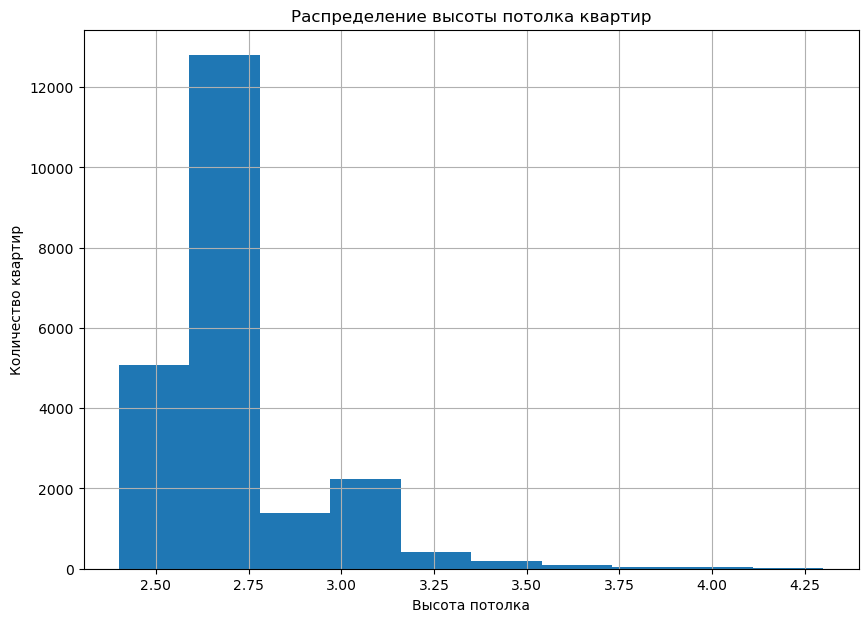

In [53]:
data['ceiling_height'].hist(bins = 10, figsize = (10,7))
plt.xlabel('Высота потолка')
plt.ylabel('Количество квартир')
plt.title('Распределение высоты потолка квартир');

Гистограмма высоты потолков показывает распределение значений среди исследуемых квартир. Наиболее часто встречаемые высоты потолков концентрируются в диапазоне от 2.5 до 2.7 метров, что является стандартным для большинства жилых зданий.

Основной пик распределения приходится на примерно 2.65 метра, что доминирует среди всех значений. Также виден второй, меньший пик около 3.0 метров, что может соответствовать более просторным и роскошным жилым помещениям.

Заполнил пропущенные значения высоты потолковов медианным значением по группам, в старых районах рассположенных в пределах 7000 метров, высота потолков выше, в новых на расстоянии больше 7000 метрв, где строят нововстройки по современным стандартам, высота потолков будет ниже

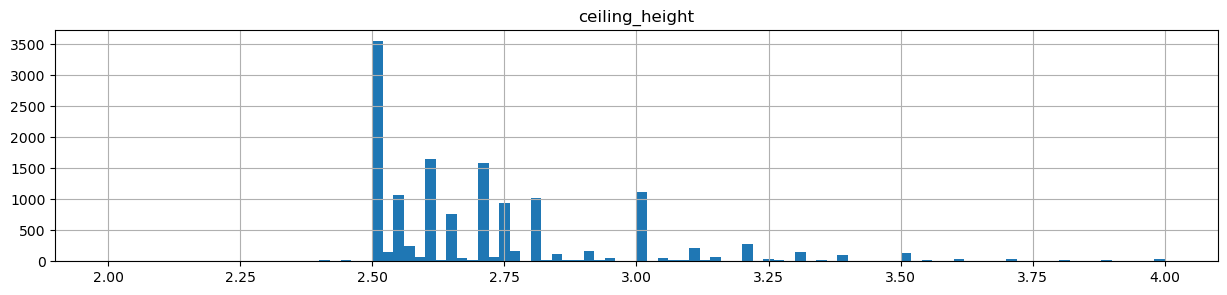

In [54]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')
    
df_check .hist(column = 'ceiling_height', bins = 100, figsize = (15,3), range = (2,4));

**Изучим тип этажа квартиры («первый», «последний», «другой»); и пострим гистограмму**

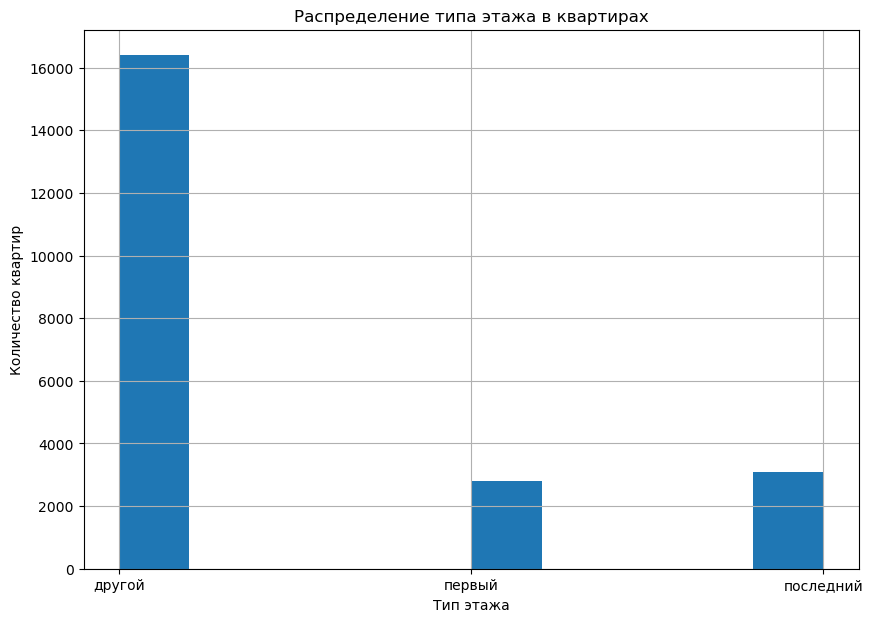

In [55]:
data['type_of_floor'].hist(bins=10,figsize=(10,7))
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир')
plt.title('Распределение типа этажа в квартирах');

Из полученной гистограммы мы можем наблюдать что больше всего обьявлеий категории другие этажи, меньше всего первый этаж и чуть больше первого, последний этаж

**Изучим общее количество этажей в доме и пострим гистограмму**

На изначальной гистограмме количество зданий с этажностью выше 25 резко снижается, и эти значения можно считать необычными для стандартного жилого фонда. Поэтому исключим их

In [56]:
data = data.query('floors_total <= 25')

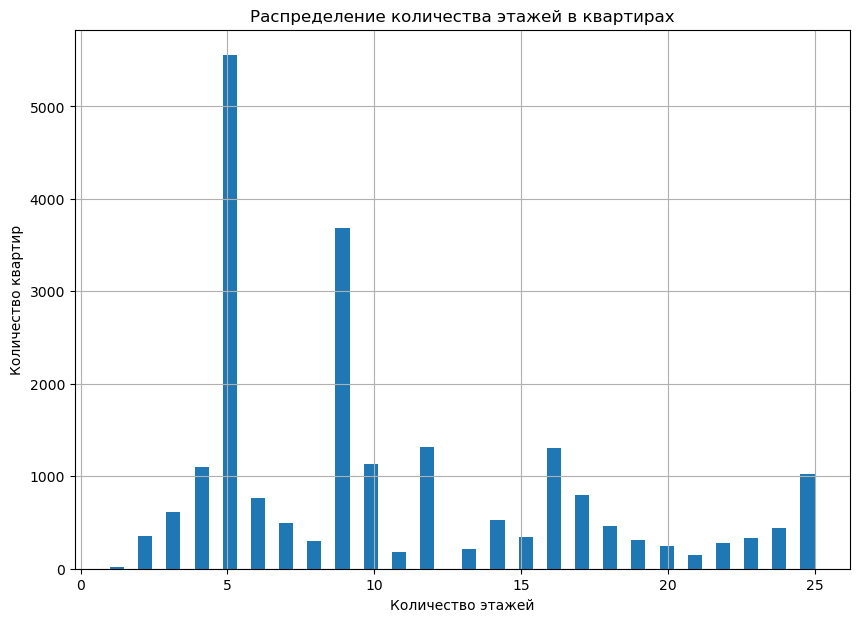

In [57]:
data['floors_total'].hist(bins=50,figsize=(10,7))
plt.xlabel('Количество этажей')
plt.ylabel('Количество квартир')
plt.title('Распределение количества этажей в квартирах');

Из полученной гистограммы можно наблюдать, что основной пик обьявлений с 5 этажами, второй пик с 9 этажами и третий с 25

**Изучим параметр расстояние до центра города в метрах и пострим гистограмму**

На изначальной гистограмме , расстояние до центра города в метрах, значения после 37000 метров резко снижаются и появляются выбросы, отбросим эти значения для получения более нужным данных для анализа

#### check nan

In [58]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21952 entries, 0 to 23698
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21952 non-null  int64         
 1   last_price              21952 non-null  float64       
 2   total_area              21952 non-null  float64       
 3   first_day_exposition    21952 non-null  datetime64[ns]
 4   rooms                   21952 non-null  int64         
 5   ceiling_height          21952 non-null  float64       
 6   floors_total            21952 non-null  int64         
 7   living_area             21952 non-null  float64       
 8   floor                   21952 non-null  int64         
 9   is_apartment            2575 non-null   object        
 10  studio                  21952 non-null  bool          
 11  open_plan               21952 non-null  bool          
 12  kitchen_area            21952 non-null  float64    

In [59]:
indexes_to_drop = data[data['cityCenters_nearest'] >= 37000].index

data.drop(index=indexes_to_drop, inplace=True)

In [60]:
# check
data.shape[0]

21642

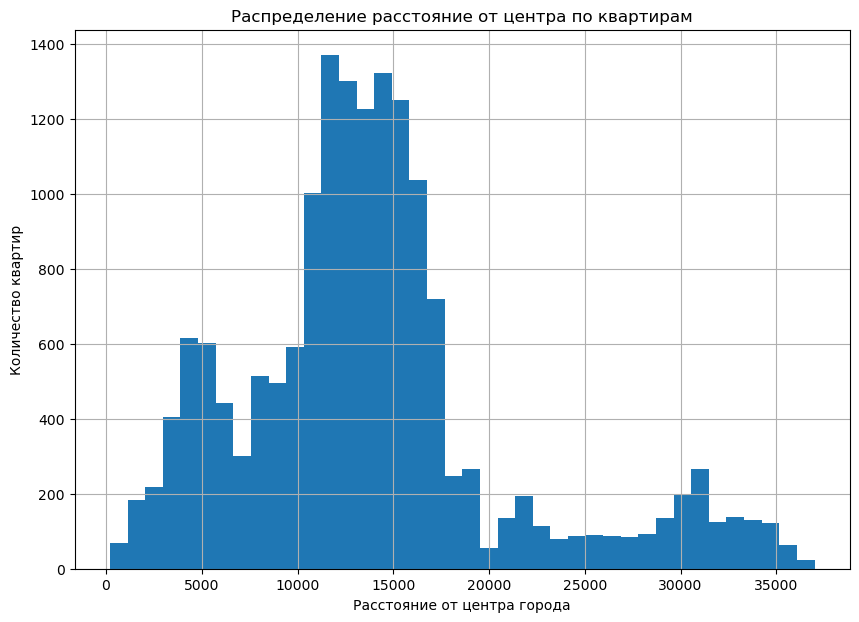

In [61]:
data['cityCenters_nearest'].hist(bins=40,figsize=(10,7))
plt.xlabel('Расстояние от центра города')
plt.ylabel('Количество квартир')
plt.title('Распределение расстояние от центра по квартирам');

На гистограмме расстояния от квартир до центра города видно, что большинство квартир расположены в пределах от 12000 до 15.000 метров от центра, что соответствует приблизительно 15 километрам. Видно два вторичных пика: первый около 5,000 метров и второй около 10,000 метров, что может указывать на наличие крупных жилых районов на этих расстояниях от центра города.

**Изучим параметр расстояние до расстояние до ближайшего парка и пострим гистограмму**

На изначальной гистограмме , расстояние до ближайшего парка, значения после 2500 метров появляются выбросы, на графкие рассмотрим значения до 2500 метров для получения более наглядных данных для анализа

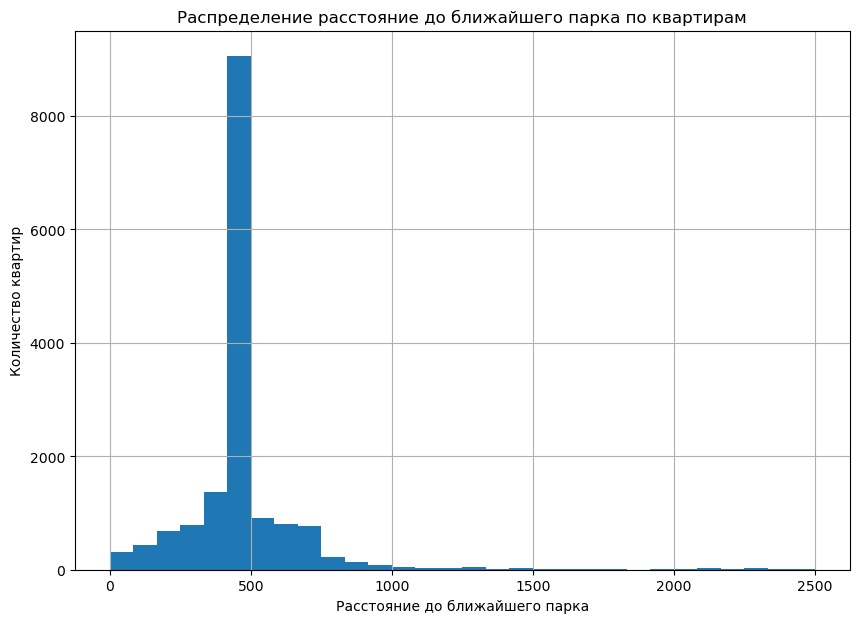

In [62]:
data['parks_nearest'].hist(bins=30,figsize=(10,7),range=[0,2500])
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество квартир')
plt.title('Распределение расстояние до ближайшего парка по квартирам');

Можем наблюдать, что основной пик квартир находятся на расстоянии 450-600 метров от парка, вторичный пик - это расстояние от 300 до 450 метров, но нужно учитывать что эти данные автоматически заполняются и большинство часть обьявлений мы заполнили самостоятельно, поэтому нужно ориентироваться по вторичному пику 

#### check gap

In [63]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21642 entries, 0 to 23698
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21642 non-null  int64         
 1   last_price              21642 non-null  float64       
 2   total_area              21642 non-null  float64       
 3   first_day_exposition    21642 non-null  datetime64[ns]
 4   rooms                   21642 non-null  int64         
 5   ceiling_height          21642 non-null  float64       
 6   floors_total            21642 non-null  int64         
 7   living_area             21642 non-null  float64       
 8   floor                   21642 non-null  int64         
 9   is_apartment            2533 non-null   object        
 10  studio                  21642 non-null  bool          
 11  open_plan               21642 non-null  bool          
 12  kitchen_area            21642 non-null  float64    

In [64]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max','median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,642.00","21,642.00","21,642.00","18,832.00","21,642.00","21,642.00","21,642.00","21,642.00","21,642.00"
min,1.00,20.60,2.40,1.00,"12,190.00",10.08,4.05,1.00,1.00
max,5.00,197.00,4.30,"1,580.00","19,999,000.00",108.00,49.40,25.00,25.00
median,2.00,51.20,2.60,94.00,"4,600,000.00",30.00,9.40,4.00,9.00


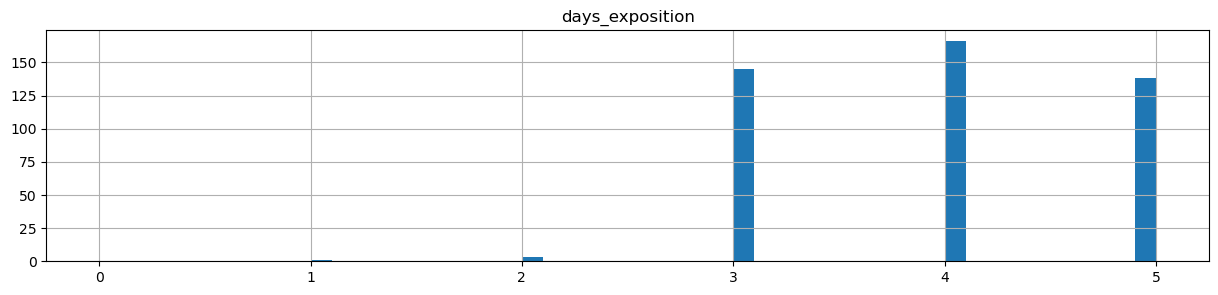

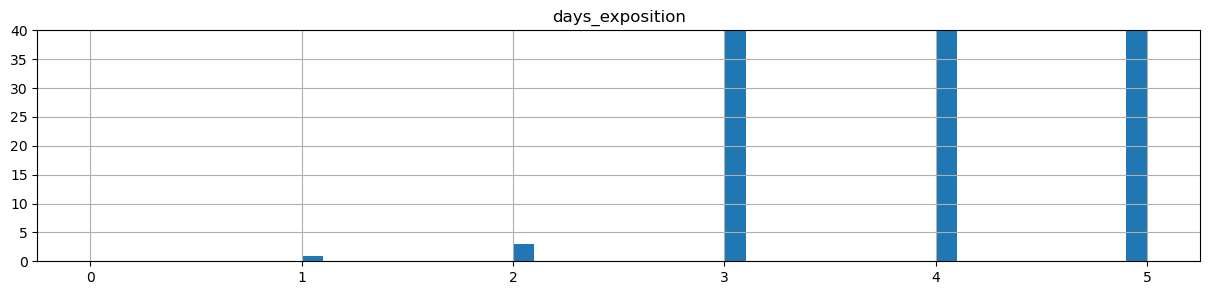

In [65]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [66]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [67]:
# check
df_check.rooms.value_counts().to_frame()

,count
rooms,
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12


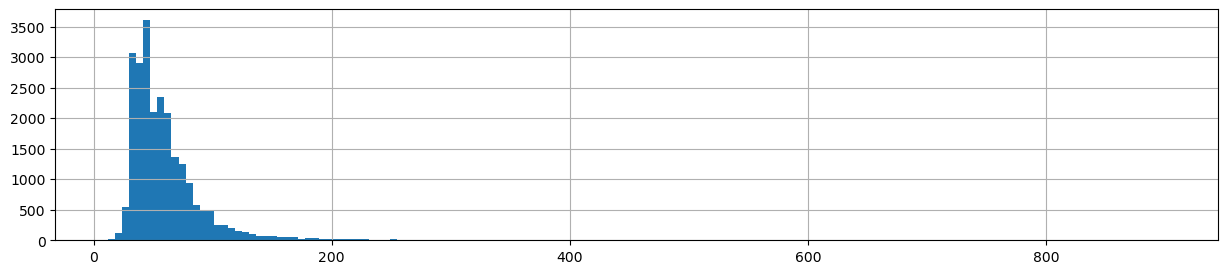

In [68]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

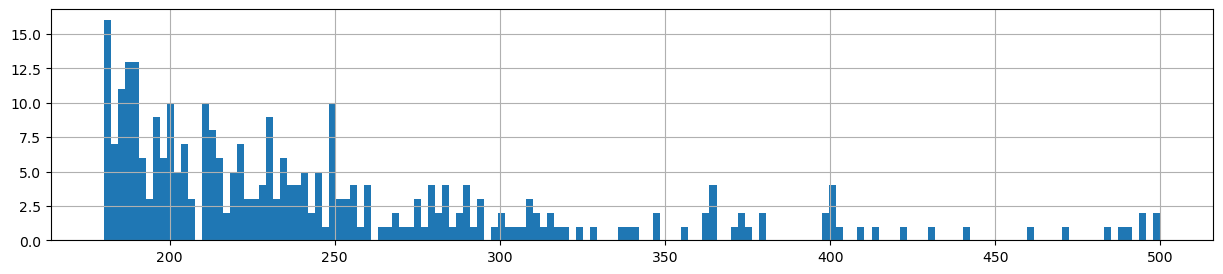

In [69]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

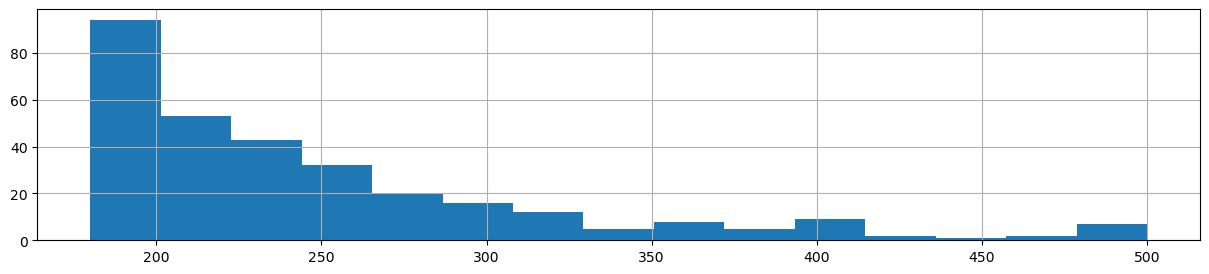

In [70]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

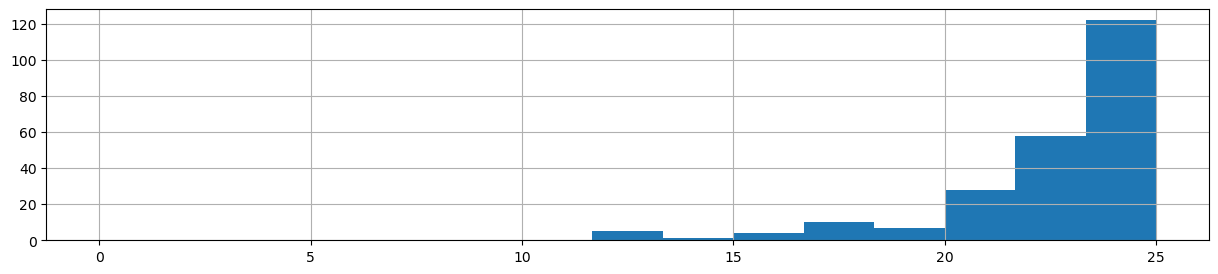

In [71]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));


В некоторых параметрах встречаются редкие и выбивающиеся значения. При построении гистограмм удалите их. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Попробуйте обработать аномалии в этом и других столбцах, если они есть. Если природа аномалии понятна и данные действительно искажены, то восстановите    корректное значение. В противном случае удалите редкие и выбивающиеся значения. 
        
__Критичный уровень потерь записей на этапе предобработки составляет 10%, оптимальный 5%__
        
Если при фильтрации одной колонки, на этом проекте, теряем больше одного процента данных от изначального объема, стоит еще раз пересмотреть условия фильтрации        

In [72]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,1.00,23.00,2.45,3.00,"560,000.00",11.00,4.50,1.00,2.00
0.010000,1.00,28.24,2.50,4.00,"990,000.00",13.90,5.00,1.00,2.00
0.500000,2.00,51.20,2.60,94.00,"4,600,000.00",30.00,9.40,4.00,9.00
0.990000,4.00,130.68,3.50,"1,054.00","16,800,000.00",80.00,32.82,22.00,25.00
0.998800,5.00,165.81,4.00,"1,361.40","19,500,000.00",100.42,44.01,25.00,25.00


#### check

**Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.**

<Axes: >

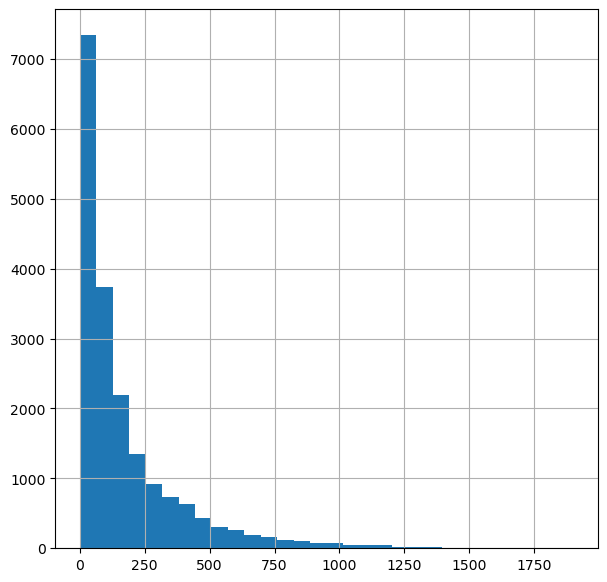

In [73]:
data['days_exposition'].hist(bins=30, figsize = (7,7), range = [0, 1900])

In [74]:
mean_sale = data['days_exposition'].mean()
median_sale = data['days_exposition'].median()
print(f'Среднее время продажи квартир {mean_sale}')
print(f'Медианное время продажи квартир {median_sale}')

Среднее время продажи квартир 177.97270603228546
Медианное время продажи квартир 94.0


Из гистограммы видно, что большинство продаж происходит в первые 100 дней после размещения объявления, с очень высоким пиком в начальном периоде.

Анализ гистограммы:

Среднее время продажи квартир составляет 177 дня. Это значение включает в себя длинные продажи, что может исказить общее представление.
Медианное время продажи квартир составляет 94 дня, что более точно отражает "типичный" сценарий продажи, поскольку медиана менее чувствительна к выбросам.
Описание типичного времени продажи:

Продажи, которые занимают до 94 дня, можно считать нормальными.
Быстрые продажи могут быть определены как те, что происходят в течение первых 30-45 дней после размещения объявления. Это значительно ниже медианного значения и указывает на высокий спрос или возможно низкую цену.
Необычно долгие продажи могут быть теми, что превышают 180 дней. Такие продажи выходят за рамки стандартного отклонения от медианы, что может указывать на проблемы с недвижимостью, неправильную цену, мошшенической деятельностью либо продавец мог просто забросить свое объявление и не завершить его или другие рыночные факторы.
Таким образом, этот анализ позволяет увидеть, как динамика продаж квартир распределяется с течением времени и помогает идентифицировать как быстрые, так и затяжные продажи на рынке недвижимости.

Поэтому исключим продажи квартиры с длиной в 355 и более дней

In [75]:
indexes_to_drop_days = data[data['days_exposition'] >= 355].index

data.drop(index=indexes_to_drop_days, inplace=True)

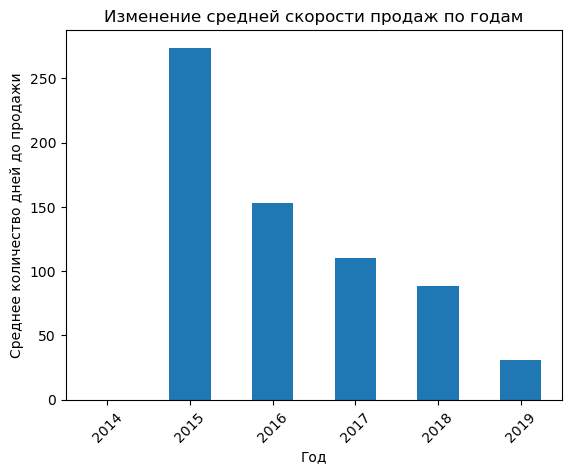

In [76]:
average_sales_speed_by_year = data.groupby('year')['days_exposition'].mean()
average_sales_speed_by_year.plot(kind='bar')
plt.title('Изменение средней скорости продаж по годам')
plt.xlabel('Год')
plt.ylabel('Среднее количество дней до продажи')
plt.xticks(rotation=45)  
plt.show()

C кажддым годом средняя скрость продажи квартир увеличиваются, думаю что это напрямую связано с развитием приложений и сайтов для выставлений обьявлений, с помощью этих средств, больше людей может посмотреть квартиру и тем самым продавец сможет быстрее ее продать

**Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.
Изучим, зависит ли цена от:**

- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Построим графики, которые покажут зависимость цены от указанных выше параметров. 

**Зависимость цены от общей площади**

Посчитаем корреляцию между общей площадью и ценой квартиры в миллионах

In [77]:
correlation = data['total_area'].corr(data['last_price_million'])
print(f'Корреляция между общей площадью и ценой составляет: {correlation}')

Корреляция между общей площадью и ценой составляет: 0.7594832111457024


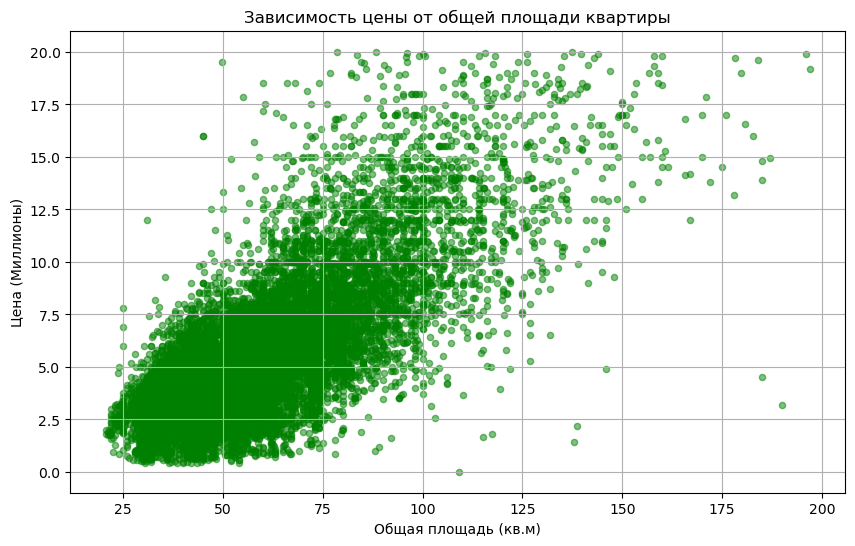

In [78]:
plt.figure(figsize=(10, 6))
plt.scatter(data['total_area'], data['last_price_million'], alpha=0.5,color='green', s=20)
plt.title('Зависимость цены от общей площади квартиры')
plt.xlabel('Общая площадь (кв.м)')
plt.ylabel('Цена (Миллионы)')
plt.grid(True)
plt.show()

Коэффициент корреляции составляет приблизительно 0.8, что указывает на достаточно сильную положительную корреляцию между общей площадью и ценой. Это означает , что увеличение общей площади тесно связано с увеличением цены на квартиру

**Зависимость цены от жилой площади**

Посчитаем корреляцию между жилой площадью и ценой квартиры в миллионах

In [79]:
correlation = data['living_area'].corr(data['last_price_million'])
print(f'Корреляция между жилой площадью и ценой составляет: {correlation}')

Корреляция между жилой площадью и ценой составляет: 0.6423949683695629


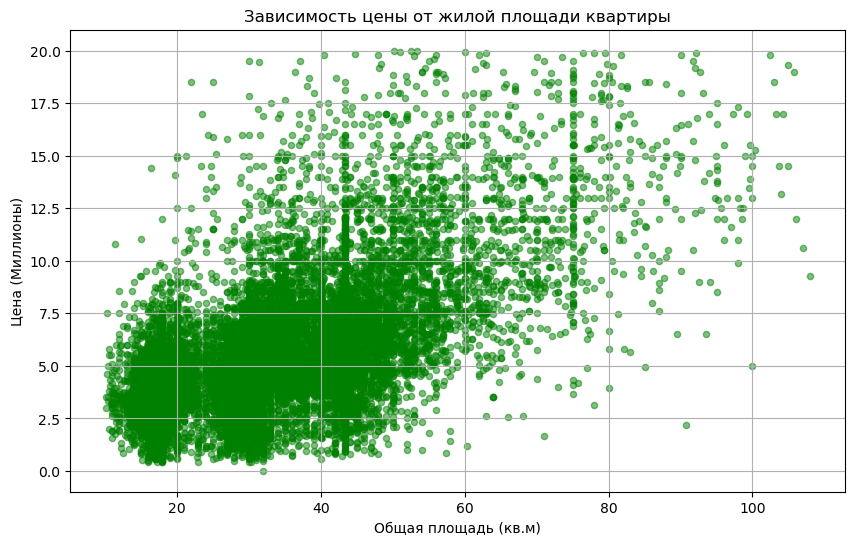

In [80]:
plt.figure(figsize=(10, 6))
plt.scatter(data['living_area'], data['last_price_million'], alpha=0.5,color='green', s=20)
plt.title('Зависимость цены от жилой площади квартиры')
plt.xlabel('Общая площадь (кв.м)')
plt.ylabel('Цена (Миллионы)')
plt.grid(True)
plt.show()

График показывает зависимость цены квартиры (в миллионах рублей) от общей жилой площади (в квадратных метрах). Наблюдается явная положительная корреляция: с увеличением жилой площади растет и цена квартиры. Распределение точек показывает, что при меньшей площади данные более сконцентрированы, а при увеличении площади разброс цен становится шире.

Коэффициент корреляции составляет приблизительно 0.69, что указывает на умеренно сильную положительную корреляцию между жилой площадью и ценой. Это означает, что как правило, увеличение жилой площади связано с увеличением цены на квартиру

**Зависимость цены от площади кухни**

Посчитаем корреляцию между площадью кухни и ценой квартиры в миллионах

In [81]:
correlation = data['kitchen_area'].corr(data['last_price_million'])
print(f'Корреляция между жилой площадью и ценой составляет: {correlation}')

Корреляция между жилой площадью и ценой составляет: 0.49282200922556807


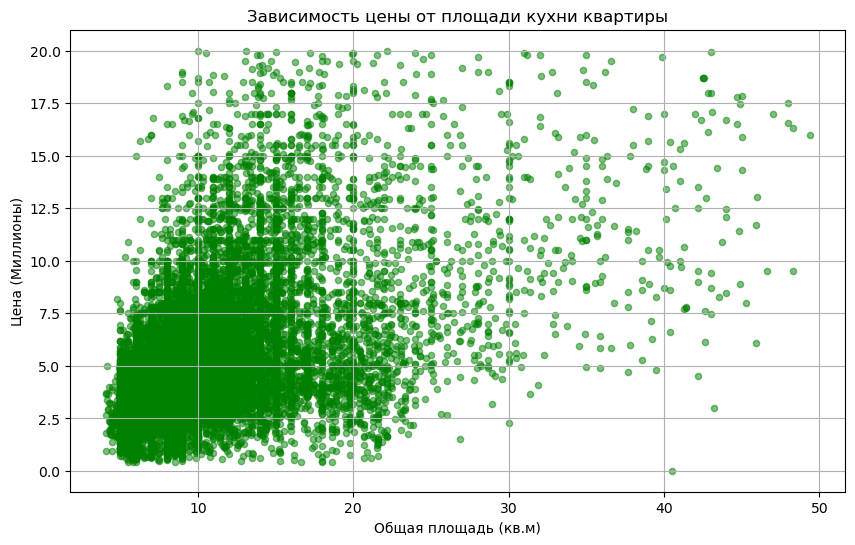

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(data['kitchen_area'], data['last_price_million'], alpha=0.5,color='green', s=20)
plt.title('Зависимость цены от площади кухни квартиры')
plt.xlabel('Общая площадь (кв.м)')
plt.ylabel('Цена (Миллионы)')
plt.grid(True)
plt.show()

График показывает рассеяние цен на квартиры (в миллионах рублей) в зависимости от площади кухни (в квадратных метрах). Точки на графике демонстрируют, что с увеличением площади кухни цена квартиры также имеет тенденцию к увеличению, особенно заметно это до площади кухни около 25 кв.м.

Коэффициент корреляции между площадью кухни и ценой квартиры составляет 0.45, что указывает на умеренную положительную корреляцию. Это означает, что хотя существует связь между увеличением площади кухни и увеличением цены квартиры, она не является очень сильной. 

**Зависимость цены от количества комнат**

Посчитаем корреляцию между количеством комнат и ценой квартиры в миллионах

In [83]:
correlation = data['rooms'].corr(data['last_price_million'])
print(f'Корреляция между количеством комнат и ценой составляет: {correlation}')

Корреляция между количеством комнат и ценой составляет: 0.4692899160717746


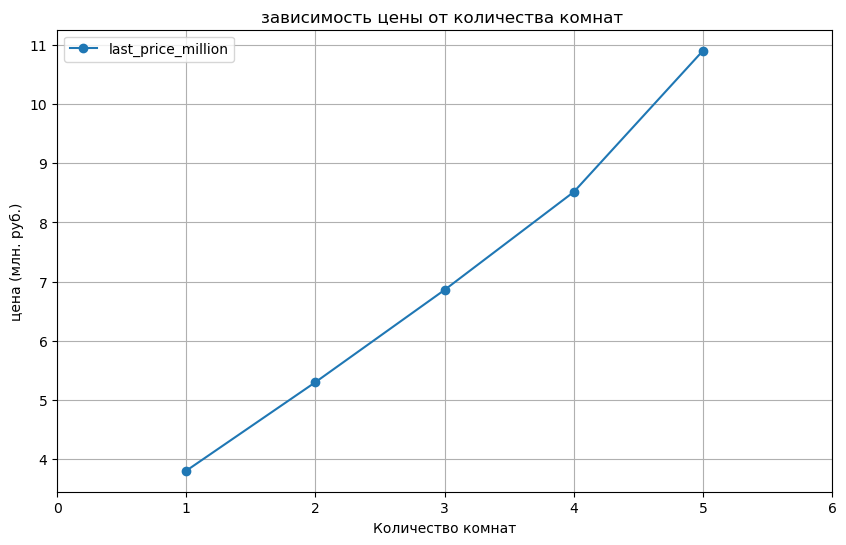

In [84]:
(
    data
    .pivot_table(index='rooms', values='last_price_million')
    .plot(grid=True, style='o-', xlim=(0,6), figsize= (10, 6))
)
plt.title('зависимость цены от количества комнат ') 
plt.xlabel('Количество комнат')
plt.ylabel('цена (млн. руб.)')
plt.show()

График показывает линейную зависимость между количеством комнат в квартире и средней ценой на квартиры, измеряемую в миллионах рублей. С ростом количества комнат средняя цена квартиры увеличивается. Это показывает, что более просторные квартиры с большим количеством комнат в среднем стоят дороже.

Коэффициент корреляции между количеством комнат и ценой составляет приблизительно 0.51, что указывает на умеренную положительную связь. Это означает, что хотя тенденция повышения цены с увеличением количества комнат очевидна, влияние других факторов также значительно 

**Зависимость цены от этажа, на котором расположена квартира (первый, последний, другой)**

Посчитаем корреляцию между типом этажа и ценой

In [85]:
# Присваиваем числовые значения категориям
data['type_of_floor_encoded'] = data['type_of_floor'].map({'первый': 1, 'последний': 2, 'другой': 3})

# Расчёт корреляции Пирсона
correlation = data['type_of_floor_encoded'].corr(data['last_price_million'])
print('Корреляция между типом этажа и ценой:', correlation)


Корреляция между типом этажа и ценой: 0.1368871126565287


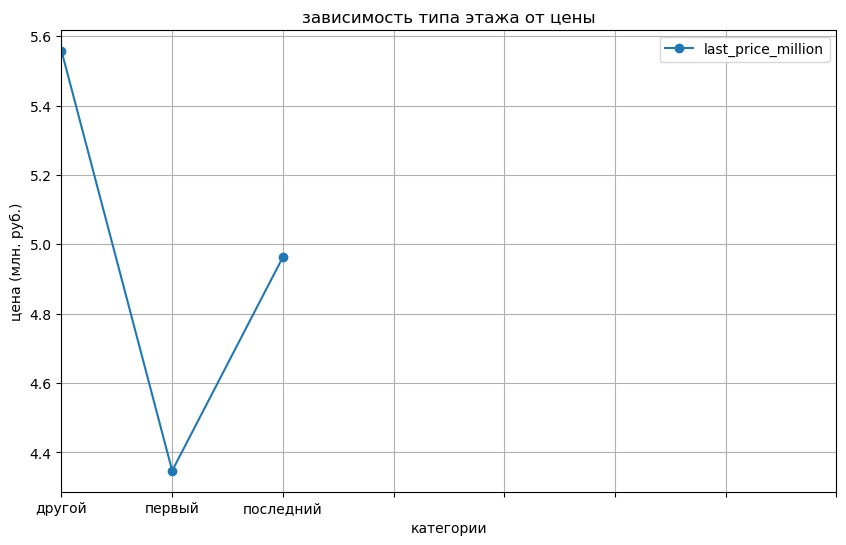

In [86]:
(
    data
    .pivot_table(index='type_of_floor', values='last_price_million')
    .plot(grid=True, style='o-', xlim=(0,7), figsize= (10, 6))
)
plt.title('зависимость типа этажа от цены') 
plt.xlabel('категории')
plt.ylabel('цена (млн. руб.)')
plt.show()

Корреляция между типами этажа и ценой состоявляет 0.09, это показывает, что между ними практически нет зависимости 

**Зависимость цены от даты размещения (день недели, месяц, год).**

**Зависимость цены от дня недели размещения объявления**

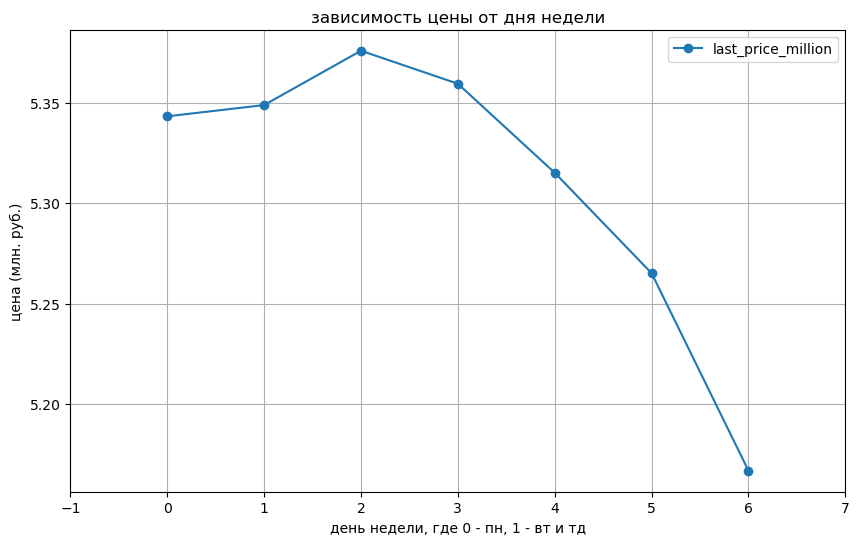

In [87]:
(
    data
    .pivot_table(index='day_of_week', values='last_price_million')
    .plot(grid=True, style='o-', xlim=(-1,7), figsize= (10, 6))
)
plt.title('зависимость цены от дня недели') 
plt.xlabel('день недели, где 0 - пн, 1 - вт и тд')
plt.ylabel('цена (млн. руб.)')
plt.show()

Снижение активности: Возможно, что в выходные дни активность покупателей снижается. Люди могут быть более заняты отдыхом и семейными делами, из-за чего меньше времени уделяется поискам недвижимости. При этом продавцы, желая привлечь внимание покупателей, могут снижать цены.

Психологический фактор: Выходные — это время, когда люди менее склонны заниматься деловой активностью, и они могут быть менее настроены на серьёзные покупки, такие как недвижимость. Это также может приводить к временному снижению цен.

Стратегия продавцов: Продавцы могут использовать стратегию снижения цен в выходные дни, чтобы стимулировать спрос. Если покупатели знают, что в выходные можно купить квартиру дешевле, это может привести к увеличению числа сделок именно в эти дни.

**Зависимость цены от месяца размещения объявления**

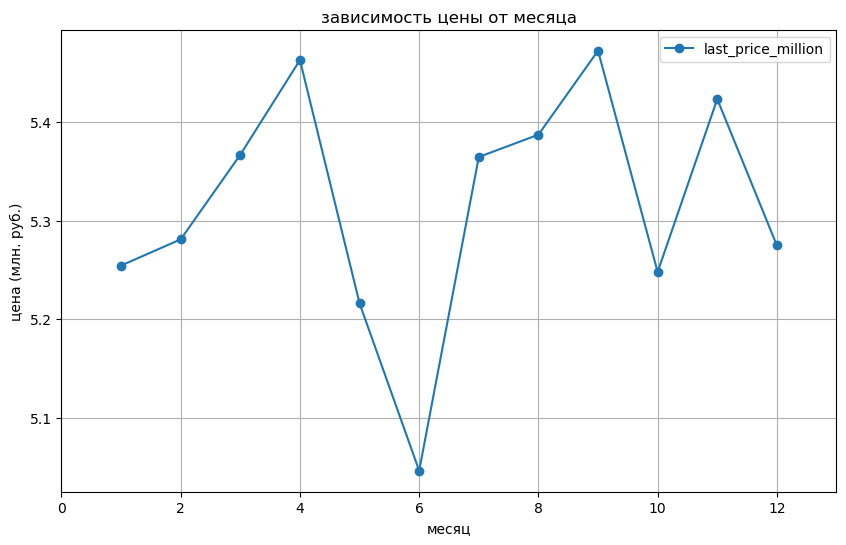

In [88]:
(
    data
    .pivot_table(index='month', values='last_price_million')
    .plot(grid=True, style='o-', xlim=(0,13), figsize= (10, 6))
)
plt.title('зависимость цены от месяца') 
plt.xlabel('месяц')
plt.ylabel('цена (млн. руб.)')
plt.show()

**Зависимость цены от года размещения объявления**

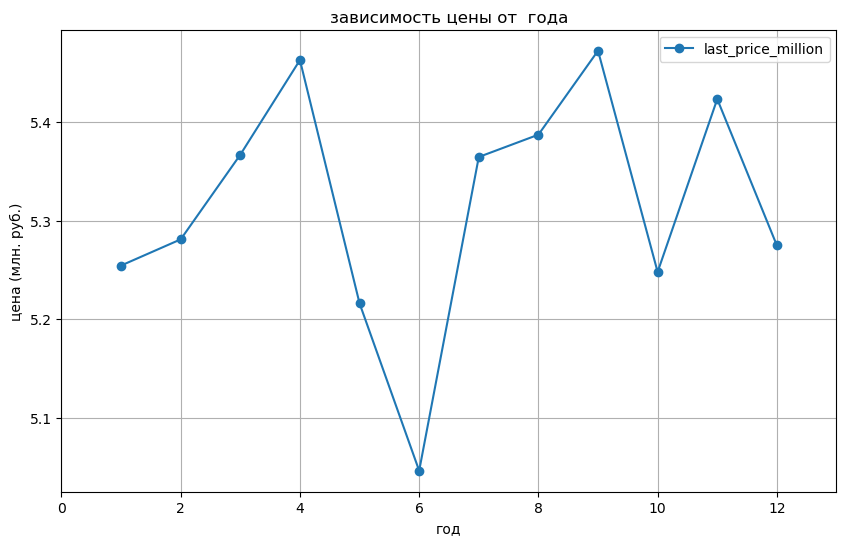

In [89]:
(
    data
    .pivot_table(index='month', values='last_price_million')
    .plot(grid=True, style='o-', xlim=(0,13), figsize= (10, 6))
)
plt.title('зависимость цены от  года') 
plt.xlabel('год')
plt.ylabel('цена (млн. руб.)')
plt.show()

**Промежуточный вывод:**

Факторы, которые больше всего влияют на общую стоимость объекта - это общая и жилая площадь квартиры, площадь кухни и количество комнта так же производят умеренное влияение на цену.

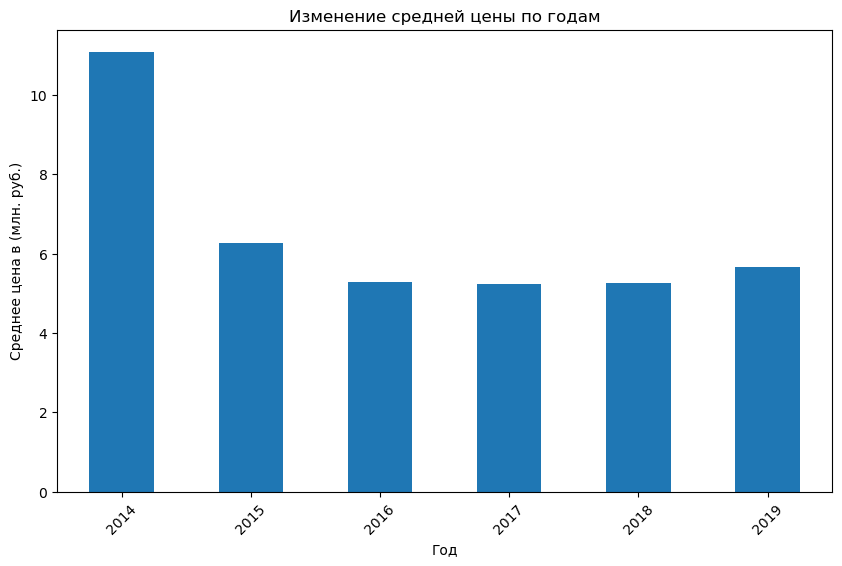

In [90]:
by_year = data.groupby('year')['last_price_million'].mean()
by_year.plot(kind='bar',figsize=(10,6))
plt.title('Изменение средней цены по годам')
plt.xlabel('Год')
plt.ylabel('Среднее цена в (млн. руб.)')
plt.xticks(rotation=45)  
plt.show()

Цена с годами уменьшалась, должно быть это связано c расширением города и созданием более доступного жилья

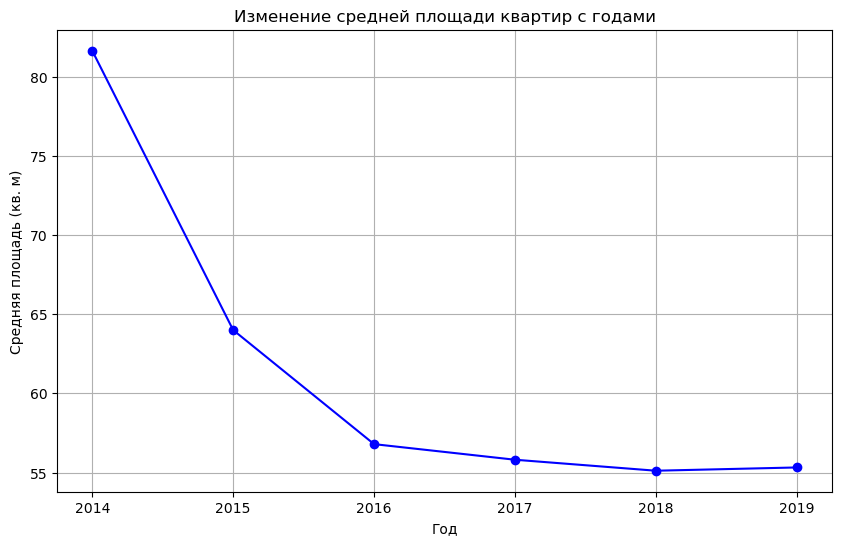

In [91]:
by_year_total_area = data.groupby('year')['total_area'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(by_year_total_area['year'], by_year_total_area['total_area'], marker='o', linestyle='-', color='b')
plt.title('Изменение средней площади квартир с годами')
plt.xlabel('Год')
plt.ylabel('Средняя площадь (кв. м)')
plt.grid(True)
plt.xticks(by_year_total_area['year'].unique())  # Убедитесь, что на оси X отображаются все годы
plt.show()

Средняя площадь с годами тоже уменьшается, что так же объясняет снижение цен на недвижимость

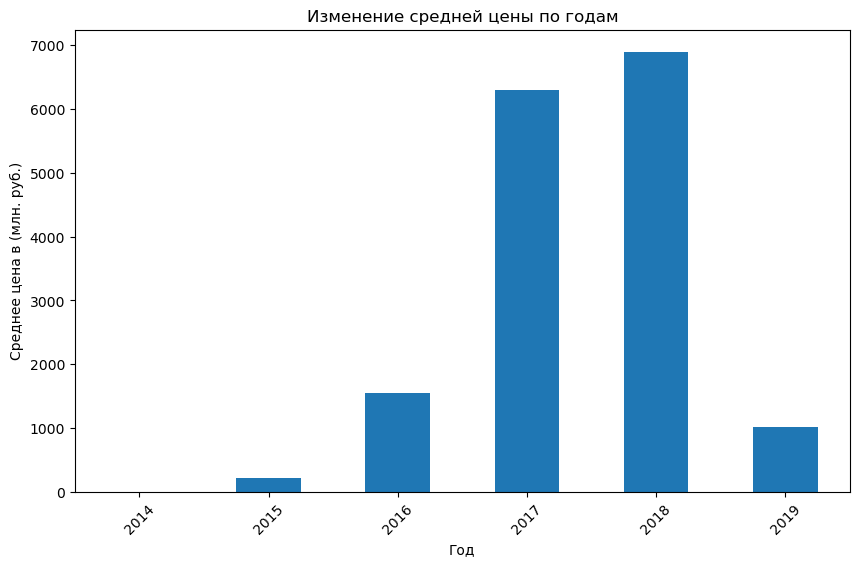

In [92]:
by_days_exposition = data.groupby('year')['days_exposition'].count()
by_days_exposition.plot(kind='bar',figsize=(10,6))
plt.title('Изменение средней цены по годам')
plt.xlabel('Год')
plt.ylabel('Среднее цена в (млн. руб.)')
plt.xticks(rotation=45)  
plt.show()

Обьявления с годами увеличивались, в 2019 виден спад, но это лишь из-за маленькой выборки для этого года

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра**

In [93]:
grouped_data = (
    data.groupby('locality_name')
    .agg({'price_of_one_metr': 'mean', 'locality_name': 'count'})
    .rename(columns={'locality_name': 'count'})
    .sort_values(by = 'count', ascending=False)
    .round(2)
)

print(grouped_data.head(10))

                   price_of_one_metr  count
locality_name                              
Санкт-Петербург            108480.01  12519
поселок Мурино              85231.81    389
поселок Шушары              78742.44    381
Всеволожск                  67565.49    334
Пушкин                     101723.59    311
Колпино                     75064.48    301
Гатчина                     69162.08    259
деревня Кудрово             92717.13    237
Выборг                      58024.09    202
поселок Парголово           85417.08    176


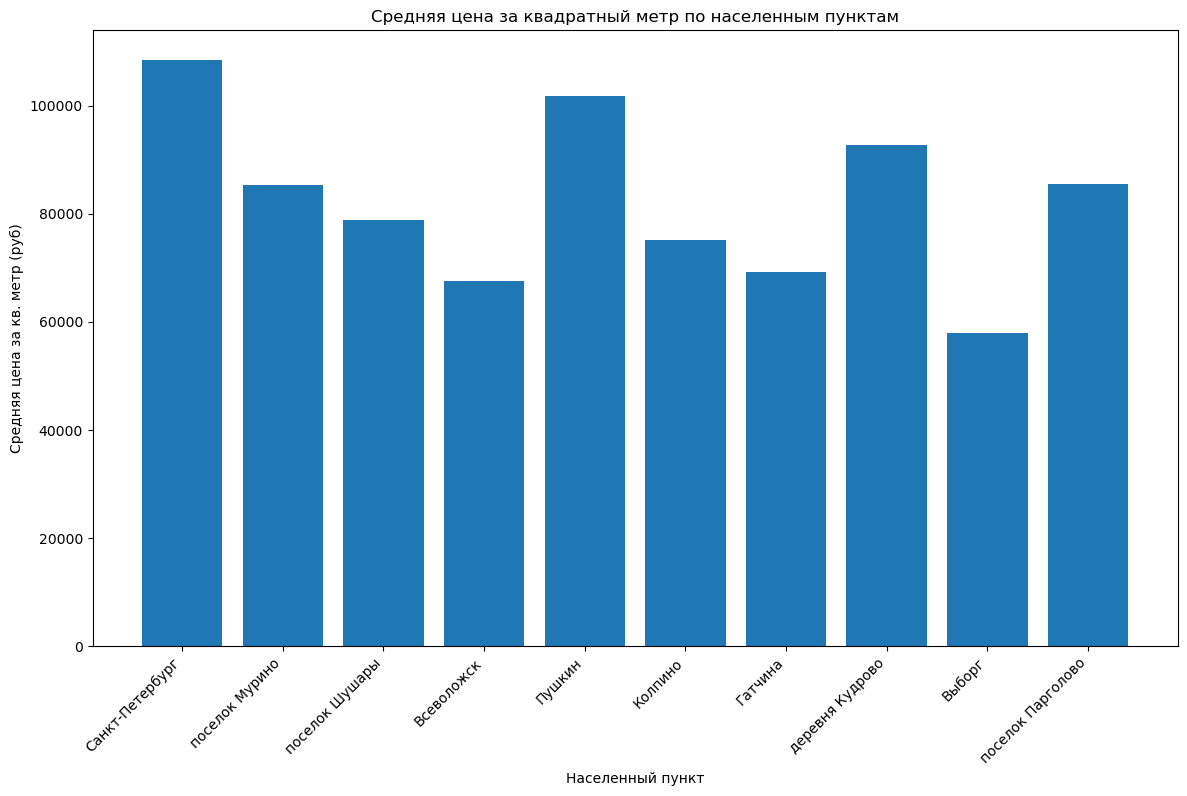

In [94]:
plt.figure(figsize=(14, 8))

plt.bar(grouped_data.head(10).index, grouped_data.head(10)['price_of_one_metr'])

plt.xlabel('Населенный пункт')
plt.ylabel('Средняя цена за кв. метр (руб)')
plt.title('Средняя цена за квадратный метр по населенным пунктам')

plt.xticks(rotation=45, ha='right')

plt.show()

Из полученной таблицы, мы можем сделать вывод ,что самая дорогая цена за квадратный метр находиться в Санкт-Петербурге и состовляет 108480.01 рублей ,а самая дешевая цена за квадратный метр находиться в Всеволожске и состовляет  58024.09 рублей 

**Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра. Будем Учитывайть каждый километр расстояния: узнаем среднюю цену квартир в одном километре от центра, в двух и так далее.**

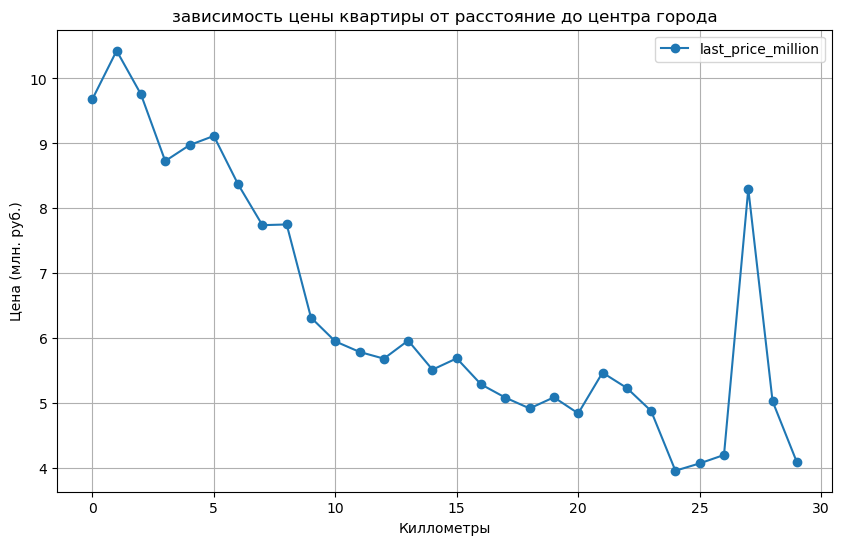

In [95]:
(
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km', values='last_price_million',aggfunc='mean')
    .plot(grid=True, style='o-',
#           xlim=(-1,15), 
#           закомментирровал твой код
          figsize= (10, 6))
)
plt.title('зависимость цены квартиры от расстояние до центра города') 
plt.xlabel('Киллометры')
plt.ylabel('Цена (млн. руб.)')
plt.show()

Близость к центру значительно увеличивает стоимость недвижимости. Пик цены находиться на интервале от 0 до 1 км

Более доступные варианты начинаются примерно с 6 км от центра. Для потенциальных покупателей, ищущих более экономичные варианты, районы на расстоянии 6 км и более, могут предложить более низкие цены при сохранении доступности городских удобств.

На 27 км цена резко возрастает, это связно с тем, что там находиться город Пушкин, в котором квадратный метр стоит в среднем почти как в Санкт-Петербурге, так же на 27 км находятся и другие населенные пункты, поэтому цена возрастает до 8.5 млн. руб. в среднем

In [96]:
pushkin_27km = data[(data['locality_name'] == "Пушкин") & (data['cityCenters_nearest_km'] == 27)]

count_pushkin_27km = pushkin_27km.shape[0]
print(f"Количество квартир в городе Пушкин на расстоянии 27 км от центра: {count_pushkin_27km}")


Количество квартир в городе Пушкин на расстоянии 27 км от центра: 56


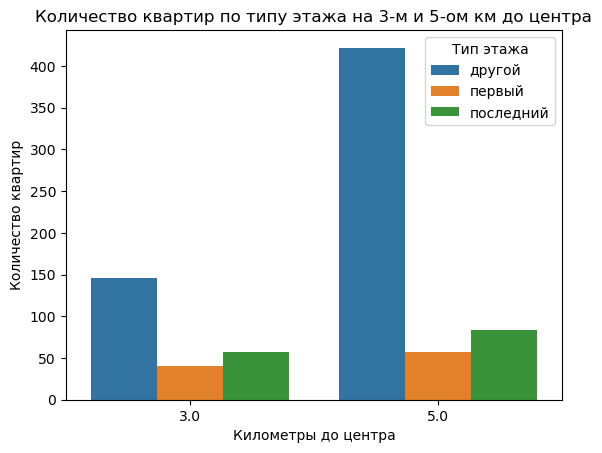

In [97]:
filtered_data = data[data['cityCenters_nearest_km'].isin([3, 5])]

# Группировка и подсчет количества квартир для каждой категории этажа
count_data = filtered_data.groupby(['cityCenters_nearest_km', 'type_of_floor']).size().reset_index(name='count')

# Построение графика
sns.barplot(data=count_data, x='cityCenters_nearest_km', y='count', hue='type_of_floor')
plt.title('Количество квартир по типу этажа на 3-м и 5-ом км до центра')
plt.xlabel('Километры до центра')
plt.ylabel('Количество квартир')
plt.legend(title='Тип этажа')
plt.show()

Из графика видно, что квартиры находящиеся ближе к центру, имеют мало этажей, поэтому категории первый, последний почти в сумме равны категории другой, из-за этого цена возрастает, а на расстоянии 5 км, дома ниже и категории другие премущественно больше, что приводит к снижению цены

### Напишите общий вывод

**Общий вывод:**

**Получив данные, мною была сделана следующая работа:**

**1.Сделана ппредобработка данных, которая включила в себя:**

- Удаление пропусков

- Обработку аномальных значений

- Изменение типов данных

- Обработка дубликатов

**2. Были добавлены в таблицу новые столбцы со следующими параметрами:**

- цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

**Проведен исследовательский анализ данных, который состоит из следующих пунктов:**

**1. Построены отдельные гистограммы для каждого из этих параметров и исключены аномалии**

**Список параметров:**
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка

**2. Изучено, как быстро продавались квартиры, построена гистограмма, подсчитано среднее и медиана**

**3.Определены факторы, которые больше всего влияют на общую (полную) стоимость объекта.**

**Изучено, зависит ли цена от:**
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Построены графики, которые показывают зависимость цены от указанных выше параметров.

**4.Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений, Выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

**5.Определено, как стоимость объектов зависит от расстояния до центра города — построен график изменения средней цены для каждого километра от центра Петербурга.** 

**По моим результатам:**


Общая площадь имеет сильную положительную корреляцию с ценой квартиры. Это подтверждает логичное предположение: чем больше площадь квартиры, тем выше её стоимость.
Жилая площадь также существенно влияет на цену, хотя её влияние немного меньше по сравнению с общей площадью. Это говорит о том, что покупатели ценят пространство, доступное для активного использования.
Площадь кухни имеет умеренное влияние на стоимость квартиры. Несмотря на меньшую корреляцию, наличие просторной кухни является значимым фактором, особенно в более дорогих сегментах рынка.
Количество комнат:

С увеличением количества комнат растет и стоимость квартиры, что отражает потребность в большем пространстве для больших семей или более высокий социальный статус.
Этажность:

Квартиры на первом и последнем этажах в среднем стоят дешевле, чем квартиры на других этажах. Это может быть связано с отсутствием видовых характеристик и возможными неудобствами (например, шумом или отсутствием балкона).
Влияние даты размещения объявления:

Анализ показал, что день недели, месяц и год размещения объявления не имеют значительного влияния на цену объекта, что может указывать на стабильность и насыщенность рынка недвижимости.
Расположение:

Квартиры в Санкт-Петербурге дороже, чем в пригородах, особенно в центре города, где цены значительно выше, что подтверждает традиционную тенденцию рынка недвижимости. Так же квартиры дороже в городе Пушкин, из - за исторической значимости этого города и нахождения возле него известных достопримечательностей
Скорость продажи:

Большинство квартир продается в первые 100 дней после размещения объявления, что говорит о высокой ликвидности рынка. Продажи, затягивающиеся более чем на полгода, могут требовать пересмотра цены или условий продажи.

Квартиры находящиеся ближе к центру, имеют мало этажей, поэтому категории первый, последний почти в сумме равны категории другой, из-за этого цена возрастает, а на расстоянии 5 км, дома ниже и категории другие премущественно больше, что приводит к снижению цены

Средняя цена за квадратный метр в населённых пунктах:
- Санкт-Петербург и Пушкин имеет самую высокую среднюю цену за квадратный метр, что подтверждает статус центра региона и исторического наследия.
- Выборг и другие небольшие населённые пункты показали более низкую стоимость, что может быть связано с удаленностью от центральных деловых районов и худшей инфраструктурой.

Рекомендации для застройщиков и риелторов:
- Уделять внимание качеству планировки и размеру жилой площади, так как это основные факторы, влияющие на стоимость.
- Рассматривать возможность развития инфраструктуры в пригородах, чтобы увеличить их привлекательность и стоимость недвижимости.
- Планировать размещение объявлений о продаже так, чтобы они были активны в периоды наибольшей активности покупателей, несмотря на незначительное влияние даты размещения на цену.

- Oбъединение населённых пунктов с различными названиями, которые фактически относятся к одному и тому же месту, является важным шагом в обработке данных. Это может улучшить точность анализа и предоставить более надёжную основу для принятия решений на основе данных. 

/Users/a0000/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


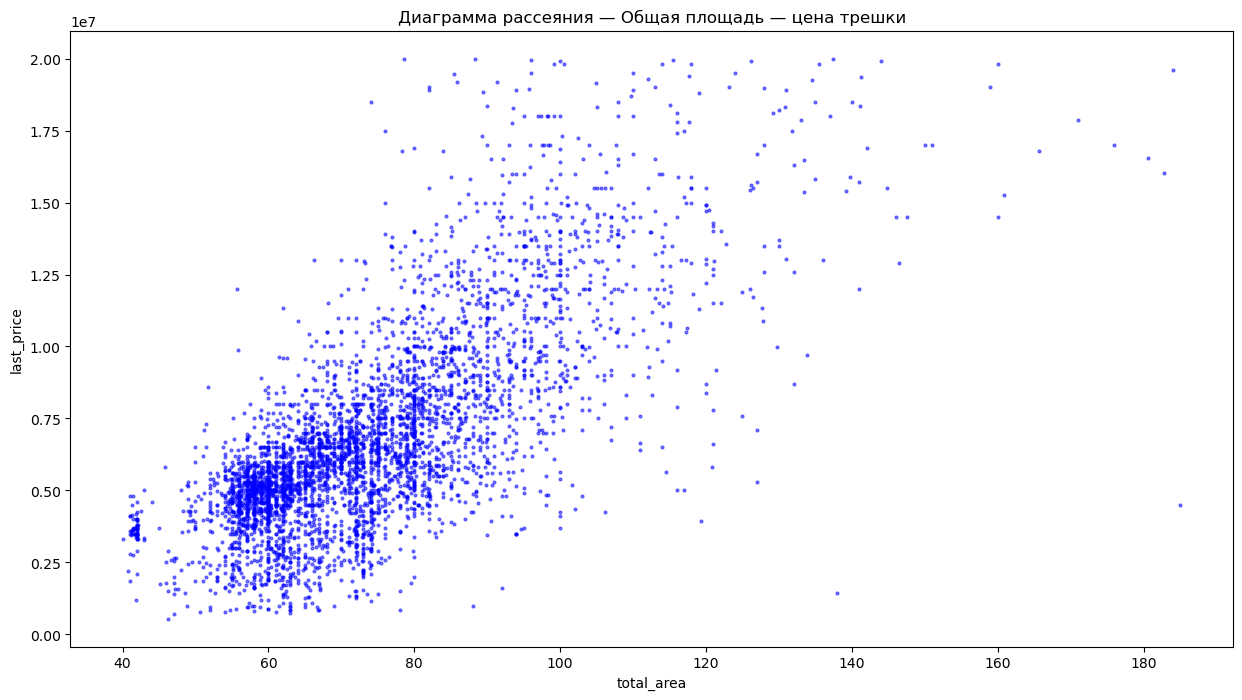

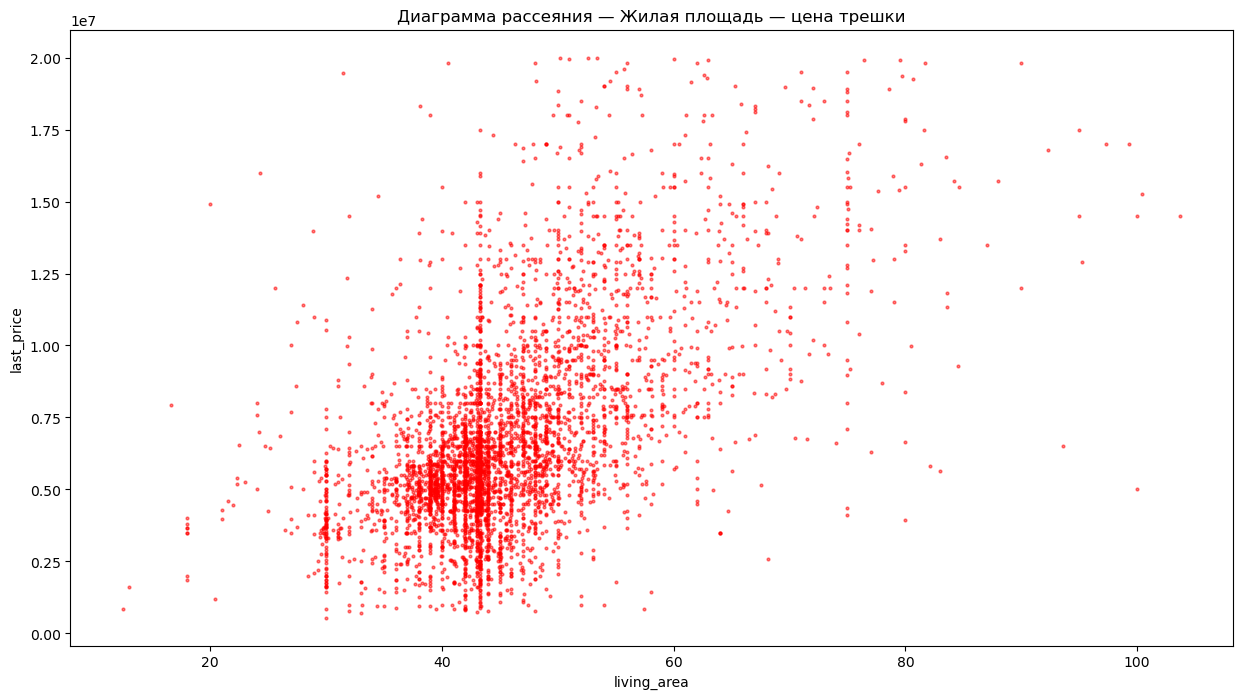

In [98]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

In [99]:
# check TOP-10
# способы группировки и сортировки информации

(
    data
    .groupby('locality_name')['last_price']
    .agg({'count', 'mean'})
    .sort_values(by = 'count', ascending = False)
    .head(10)
    
).sort_values(by = 'mean', ascending = False).style.format("{:,.0f}")

# .plot(y = 'mean', kind = 'bar')
# стайл и плот вместе не работают

,mean,count
locality_name,,
Санкт-Петербург,"6,283,943","12,519"
Пушкин,"5,779,898",311
поселок Парголово,"4,439,830",176
деревня Кудрово,"4,422,033",237
поселок Шушары,"4,145,096",381
Колпино,"3,864,393",301
Всеволожск,"3,804,063",334
поселок Мурино,"3,743,682",389
Гатчина,"3,467,353",259


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.